# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
'''
Have to run these, and then restart the kernel
#pip install jupyter-tensorboard==0.1.10
#pip install scikit-learn==0.22.2
#pip install lightgbm==3.1.1
#pip install xgboost==1.0.2
#pip3 install catboost==0.23.2
#pip install "scikit_optimize==0.7.4" 
#Restart Kernel

Specific version needed because of a reported bug 
#https://www.bountysource.com/issues/92174819-iid-parameter-to-be-removed-in-scikit-learn-0-24   
#BayesSearchCV in scikit_optimize version 0.8.0 above will hit a bug __init__() got an unexpected keyword argument 'iid'
#scikit_optimize" version 0.8.0 required scikit-learn 0.24.0 which got this bug
#scikit-learn==0.23.2 not working in combination also as it will caused error with BayesSearchCV with Catboost during fit:
TypeError: '<' not supported between instances of 'str' and 'int'
Similar with Lightgbm https://gitmemory.com/issue/microsoft/LightGBM/2610/561356696 
Hence choose scikit-learn==0.22.2 and it works



'''

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# magic word for producing visualizations in notebook
%matplotlib inline

import random
from ast import literal_eval
from workspace_utils import active_session

# pip install numpy --upgrade --user
# pip install fancyimpute
# from fancyimpute import IterativeImputer as MICE


#pip install scikit-learn==0.22.2
#from sklearn.experimental import enable_iterative_imputer  
#from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
#from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans

#pip install lightgbm==3.1.1
#pip install xgboost==1.0.2
#pip3 install catboost==0.23.2

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from time import time
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve

#pip install "scikit_optimize==0.7.4" 
#version 0.8.0 above has a bug __init__() got an unexpected keyword argument 'iid'
#https://www.bountysource.com/issues/92174819-iid-parameter-to-be-removed-in-scikit-learn-0-24    
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Real, Categorical, Integer

# Allows the use of display() for DataFrames
from IPython.display import display 
import pprint
import joblib as joblib

from catboost import Pool, cv

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [2]:

#Build the cleaning pipeline 1st with small sample to avoid long waiting everytime restart this notebook
#This cell will not be run once the cleaning pipeline completed

n = 891211 #number of records in file
s = 100000 #desired random sample size
skip = sorted(random.sample(range(1,n),n-1-s))
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',  skiprows=skip)
azdias.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,612558,-1,5.0,21.0,NaN,NaN,NaN,NaN,14.0,1.0,...,4.0,3.0,5.0,3.0,6.0,4.0,3.0,1,1,3
3,612577,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
4,612595,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,...,2.0,9.0,11.0,8.0,5.0,9.0,4.0,4,1,2


In [ ]:

#Build the cleaning pipeline 1st with small sample to avoid long waiting everytime restart this notebook
#This cell will not be run once the cleaning pipeline completed

n = 191652 #number of records in file
s = 100000 #desired random sample size
skip = sorted(random.sample(range(1,n),n-1-s))
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',  skiprows=skip)
customers.head()

In [34]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,NaN,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


### Preprocessing 1A - Run Once only throughout this project

Take the previous semester AZDIAS_Feature_Summary.csv
<br>Take the DIAS Attributes - Values 2017.xlsx provided in this project that contained the additional attributes 
<br>Combine both of them. Some manual processing is required.
<br>Generate a new feat_info.csv for ease of processing for future run.
<br>Hence this Preprocessing 1A section will only execute once throughout this project 

In [2]:
#use the steps from previous semester to process feat_info
feat_info_ori = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';' )

feat_info_ori['missing_or_unknown'] = feat_info_ori['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
feat_info_ori.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [3]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
feat_info.drop(columns=['Unnamed: 0'], inplace=True)
feat_info.head()
feat_info['Attribute'].fillna(method='ffill', inplace=True)
feat_info['Description'].fillna(method='ffill', inplace=True)
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [5]:
feat_info['Attribute'].unique().shape

(314,)

In [6]:
#Find missing or unknown values that should be converted to NaNs.
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
#feat_info

#Manually exclude few rows from the list after analyzing the records as they seems like valid "no "
feat_info.drop(index=[49, 206, 349, 590, 725, 796, 802, 808, 813, 992, 2208, 2230], inplace=True)
#feat_info

#Looking at the data, decided to keep the "no transaction known"
feat_info = feat_info[~ feat_info['Meaning'].str.contains("no transaction") ]
pd.set_option('display.max_rows', 500)

#Rename the columns
feat_info.rename(columns={'Attribute':'attribute', 'Description':'information_level', 'Value':'missing_or_unknown'}, inplace=True)

#Drop the Meaning column
feat_info.drop(columns=['Meaning'], inplace=True)
#feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: str(x).split(','))
feat_info

,attribute,information_level,missing_or_unknown
0,AGER_TYP,best-ager typology,-1
1,AGER_TYP,best-ager typology,0
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0"
11,ALTER_HH,main age within the household,0
33,ANREDE_KZ,gender,"-1, 0"
40,BALLRAUM,distance to next urban centre,-1
48,BIP_FLAG,business-flag indicating companies in the buil...,-1
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1
131,CJT_GESAMTTYP,customer journey typology,0


In [7]:
feat_info.shape

(234, 3)

In [8]:
#feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: str(x).split(','))
#feat_info

In [9]:
#There could be more than 1 row for the same attribute. Concatenate them into a list of string

unique = []
uinfo = []
for attribute in feat_info['attribute'].unique():
    row = feat_info.loc[feat_info['attribute'] == attribute]['missing_or_unknown'].astype(str).str.cat(sep=',').split(',')
    unique.append(row)
    irow = feat_info.loc[feat_info['attribute'] == attribute]['information_level'].unique().item()
    uinfo.append(irow)

feat_info = pd.concat([pd.Series(feat_info['attribute'].unique()), pd.Series(uinfo), pd.Series(unique)], axis=1)
feat_info.columns=['attribute', 'information_level', 'missing_or_unknown']

feat_info
  



,attribute,information_level,missing_or_unknown
0,AGER_TYP,best-ager typology,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]"
2,ALTER_HH,main age within the household,[0]
3,ANREDE_KZ,gender,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,[-1]
5,BIP_FLAG,business-flag indicating companies in the buil...,[-1]
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,[-1]
7,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,[-1]
8,CJT_GESAMTTYP,customer journey typology,[0]
9,D19_KK_KUNDENTYP,consumption movement in the last 12 months,[-1]


In [10]:
#Looks like only 1 attribute that has more than 1 row. Well, could have done it manually using excel
feat_info.shape

(233, 3)

In [11]:
feat_info.to_csv('feat_info_raw.csv', index=False)

feat_info= pd.read_csv('feat_info_raw.csv', sep=',' , converters={'missing_or_unknown': literal_eval})
feat_info.head()

,attribute,information_level,missing_or_unknown
0,AGER_TYP,best-ager typology,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]"
2,ALTER_HH,main age within the household,[0]
3,ANREDE_KZ,gender,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,[-1]


In [12]:
#Add column type so to be the same as the original feat_info from last semester.  

feat_info["type"] = ""
feat_info.head()

,attribute,information_level,missing_or_unknown,type
0,AGER_TYP,best-ager typology,"[-1, 0]",
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",
2,ALTER_HH,main age within the household,[0],
3,ANREDE_KZ,gender,"[-1, 0]",
4,BALLRAUM,distance to next urban centre,[-1],


In [13]:
# This is to just check whether all 85 attribute from feat_info_ori corresponce to how many attribute from feat_info_modified
# And it looks like there are 25 attributes from feat_info_ori that's not present in feat_info_modified
# I will preserved this  25 attributes 

compare_feat_info = feat_info_ori.merge(feat_info, on=['attribute'], how='left')
compare_feat_info


,attribute,information_level_x,type_x,missing_or_unknown_x,information_level_y,missing_or_unknown_y,type_y
0,AGER_TYP,person,categorical,"[-1, 0]",best-ager typology,"[-1, 0]",
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]",age classification through prename analysis,"[-1, 0]",
2,ANREDE_KZ,person,categorical,"[-1, 0]",gender,"[-1, 0]",
3,CJT_GESAMTTYP,person,categorical,[0],customer journey typology,[0],
4,FINANZ_MINIMALIST,person,ordinal,[-1],financial typology: low financial interest,[-1],
5,FINANZ_SPARER,person,ordinal,[-1],financial typology: money saver,[-1],
6,FINANZ_VORSORGER,person,ordinal,[-1],financial typology: be prepared,[-1],
7,FINANZ_ANLEGER,person,ordinal,[-1],financial typology: investor,[-1],
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],financial typology: unremarkable,[-1],
9,FINANZ_HAUSBAUER,person,ordinal,[-1],financial typology: main focus is the own house,[-1],


In [14]:
# Get only the rows that not exists in feat_info_ori 

feat_info = feat_info[~feat_info.attribute.isin(feat_info_ori.attribute)]
feat_info

,attribute,information_level,missing_or_unknown,type
5,BIP_FLAG,business-flag indicating companies in the buil...,[-1],
7,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,[-1],
9,D19_KK_KUNDENTYP,consumption movement in the last 12 months,[-1],
19,GEOSCORE_KLS7,microgeographical risk index concerning popula...,"[-1, 0]",
20,HAUSHALTSSTRUKTUR,"structure of the household (single-hh, couple ...","[-1, 0]",
24,KBA05_ALTER1,share of car owners less than 31 years old,"[-1, 9]",
25,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"[-1, 9]",
26,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"[-1, 9]",
27,KBA05_ALTER4,share of cars owners elder than 61 years,"[-1, 9]",
28,KBA05_ANHANG,share of trailers in the microcell,"[-1, 9]",


In [15]:
feat_info.shape

(173, 4)

In [16]:
#Concat the rows from feat_info_modified with feat_info_ori

feat_info = pd.concat([feat_info_ori,feat_info],axis=0).reset_index(drop=True)
feat_info


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,attribute,information_level,missing_or_unknown,type
0,AGER_TYP,person,"[-1, 0]",categorical
1,ALTERSKATEGORIE_GROB,person,"[-1, 0, 9]",ordinal
2,ANREDE_KZ,person,"[-1, 0]",categorical
3,CJT_GESAMTTYP,person,[0],categorical
4,FINANZ_MINIMALIST,person,[-1],ordinal
5,FINANZ_SPARER,person,[-1],ordinal
6,FINANZ_VORSORGER,person,[-1],ordinal
7,FINANZ_ANLEGER,person,[-1],ordinal
8,FINANZ_UNAUFFAELLIGER,person,[-1],ordinal
9,FINANZ_HAUSBAUER,person,[-1],ordinal


In [17]:
feat_info.shape

(258, 4)

In [18]:
feat_info.to_csv('feat_info_raw.csv', index=False)

In [19]:
feat_info= pd.read_csv('feat_info_raw.csv', sep=',' , converters={'missing_or_unknown': literal_eval})

In [20]:
feat_info.tail()

,attribute,information_level,missing_or_unknown,type
253,KBA13_VORB_2,share of cars with 2 preowner - PLZ8,[-1],NaN
254,KBA13_VORB_3,share of cars with 3 or more preowner - PLZ8,[-1],NaN
255,KBA13_VW,share of VOLKSWAGEN within the PLZ8,[-1],NaN
256,SOHO_FLAG,small office/home office flag,[-1],NaN
257,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"[-1, 0]",NaN


### Preprocessing 1B

<b> Manually filled the type in feat_info.csv offline referring to 'DIAS Attributes - Values 2017.xlsx' </b> <br>
<b> Added columns that are believed to be categorical in nature </b><br>
<b> Will be using this feat_info.csv for subsequent run</b><br>


#### Step 1.1: Assess Missing Data
##### Step 1.1.1: Convert Missing Value Codes to NaNs
The [missing_or_unknown] column of the feature attributes (loaded in above as feat_info) documents the codes from the data dictionary that indicate missing or unknown data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [14]:
# Read the feat_info.csv back into feat_info   
feat_info= pd.read_csv('feat_info.csv', sep=',' , converters={'missing_or_unknown': literal_eval})
feat_info.tail()

,attribute,information_level,missing_or_unknown,type
282,D19_VERSI_ONLINE_DATUM,Household,[],ordinal
283,D19_VERSI_DATUM,Household,[],ordinal
284,D19_GESAMT_ONLINE_QUOTE_12,Household,[],ordinal
285,D19_BANKEN_ONLINE_QUOTE_12,Household,[],ordinal
286,D19_VERSAND_ONLINE_QUOTE_12,Household,[],ordinal


In [2]:
import random

#Build the cleaning pipeline 1st with small sample to avoid long waiting everytime restart this notebook
#This cell will not be run once the cleaning pipeline completed

n = 891211 #number of records in file
s = 100000 #desired random sample size
skip = sorted(random.sample(range(1,n),n-1-s))
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',  skiprows=skip)
azdias.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
1,612609,-1,6.0,16.0,NaN,NaN,NaN,NaN,NaN,1.0,...,2.0,3.0,6.0,8.0,3.0,2.0,3.0,4,1,3
2,714263,-1,6.0,16.0,17.0,NaN,NaN,NaN,16.0,6.0,...,3.0,4.0,7.0,5.0,1.0,3.0,3.0,4,1,3
3,714289,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,11.0,10.0,0.0,9.0,NaN,3,2,3
4,507916,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,9.0,...,2.0,8.0,11.0,10.0,4.0,8.0,3.0,3,2,3


In [13]:
# Do a sample check before and after missing_or_unknown conversion

print(azdias.isnull().sum().sum())

print(azdias.AGER_TYP.value_counts())

azdias['AGER_TYP'].isnull().sum()

13864522
-1    92107
 2    45874
 1    40382
 3     8658
 0     4631
Name: AGER_TYP, dtype: int64


0

In [26]:
pd.set_option('display.max_rows', 500)

print(azdias.columns.tolist())

['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK

In [15]:
feat_info.drop(feat_info[feat_info['attribute']=='BIP_FLAG'].index, inplace=True)

In [16]:
feat_info.drop(feat_info[feat_info['attribute']=='CAMEO_DEUINTL_2015'].index, inplace=True)

In [17]:
feat_info.drop(feat_info[feat_info['attribute']=='D19_KK_KUNDENTYP'].index, inplace=True)

In [18]:
feat_info.drop(feat_info[feat_info['attribute']=='GEOSCORE_KLS7'].index, inplace=True)

In [19]:
feat_info.replace(['HAUSHALTSSTRUKTUR'],'STRUKTURTYP', inplace=True)

In [20]:
feat_info.replace(['KBA13_CCM_1400_2500'],'KBA13_CCM_1401_2500', inplace=True)

In [21]:
feat_info.replace(['SOHO_FLAG'],'SOHO_KZ', inplace=True)

In [22]:
feat_info.drop(feat_info[feat_info['attribute']=='WACHSTUMSGEBIET_NB'].index, inplace=True)

In [23]:
# Identify missing or unknown data values and convert them to NaNs.

for attribute, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    #beforeNaN = azdias[attribute].isnull().sum() 
    azdias.loc[azdias[attribute].isin(missing), attribute] = np.NaN
    #afterNaN = azdias[attribute].isnull().sum() 

In [24]:
# Do a sample check before and after missing_or_unknown conversion

print(azdias.isnull().sum().sum())

print(azdias.AGER_TYP.value_counts())

azdias['AGER_TYP'].isnull().sum()
# We can see that the -1 and 0 value in AGER_TYP column have been converted to NaN

14779521
2.0    45874
1.0    40382
3.0     8658
Name: AGER_TYP, dtype: int64


96738

#### Step 1.1.2: Assess Missing Data in Each Column

In [25]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#missingdata = azdias.isnull().sum()
#print (missingdata[missingdata>0]) 
missingdatapercentage = azdias.isnull().mean().sort_values(ascending=False)
missingdatapercentage[missingdatapercentage>0].head()

ALTER_KIND4    0.998769
ALTER_KIND3    0.993347
TITEL_KZ       0.987936
ALTER_KIND2    0.973389
ALTER_KIND1    0.938607
dtype: float64

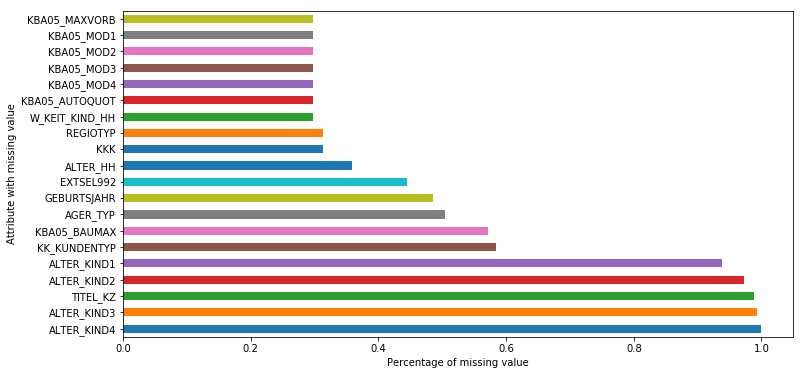

In [26]:
# Investigate patterns in the amount of top20 missing data in each column.

missingdatapercentage[missingdatapercentage>0].head(20).plot.barh(figsize=(12,6))
plt.ylabel('Attribute with missing value')
plt.xlabel('Percentage of missing value')

plt.show()

In [27]:
# Remove the outlier columns from the dataset. 
# More than 80% of missing values in these column. I treated these columns as outlier 
# for removal since so high percentage of data was missing.

cols_to_remove = []
for col in azdias.columns:
    if (azdias[col].isnull().mean() > 0.8) :
        cols_to_remove.append(col)

print(cols_to_remove)
azdias = azdias.drop(cols_to_remove, axis=1)
print(azdias.shape)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
(191652, 364)


In [28]:
print('Cols to be removed:' + str(cols_to_remove))

Cols to be removed:['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']


In [29]:
# Remove ID Columns 

for column in azdias.columns:
    if azdias[column].nunique() == len(azdias):
        print('ID Column:', column)


ID Column: LNR


In [30]:
cols_to_remove.append('LNR')
azdias = azdias.drop('LNR', axis=1)
print(azdias.shape)

(191652, 363)


#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. Either way, we should continue our analysis for now using just the subset of the data with few or no missing values.

In [31]:
# How much data is missing in each row of the dataset?

print(azdias.isnull().sum(axis=1).describe(), '\n')

missingrowdata = azdias.isnull().sum(axis=1).sort_values(ascending=False)
#print(missingrowdata[missingrowdata>0] , '\n')

missingrowdatapercentage = azdias.isnull().mean(axis=1).sort_values(ascending=False)
#print (missingrowdatapercentage[missingrowdatapercentage>0], '\n') 

print('Missing Data Points:' + str(missingrowdata[missingrowdata>0].sum()))
print('Count of Row with Missing datapoint(s):' + str(missingrowdata[missingrowdata>0].count()))
row_with_no_miss_datapoints = missingrowdata[missingrowdata==0].count() 
print('Count of Row with No Missing datapoints:' + str(row_with_no_miss_datapoints), '\n')

missingitemrowcount = 0
for cols in range(1, 360):
    print('Count of Row with {} missing data points in a row: '.format(cols) + str(missingrowdata[missingrowdata==cols].count()))
    missingitemrowcount += missingrowdata[missingrowdata==cols].count()
    print ('Percentage of rows upto {} missing data points (including rows with no missing data points): '.format(cols) + str((missingitemrowcount+row_with_no_miss_datapoints)/len(azdias) * 100))
print(missingitemrowcount)

count    191652.000000
mean         72.224396
std         110.744250
min           0.000000
25%           1.000000
50%           3.000000
75%         223.000000
max         260.000000
dtype: float64 

Missing Data Points:13841950
Count of Row with Missing datapoint(s):175524
Count of Row with No Missing datapoints:16128 

Count of Row with 1 missing data points in a row: 33992
Percentage of rows upto 1 missing data points (including rows with no missing data points): 26.151566380731744
Count of Row with 2 missing data points in a row: 33492
Percentage of rows upto 2 missing data points (including rows with no missing data points): 43.626990587105794
Count of Row with 3 missing data points in a row: 20540
Percentage of rows upto 3 missing data points (including rows with no missing data points): 54.344332435873355
Count of Row with 4 missing data points in a row: 9960
Percentage of rows upto 4 missing data points (including rows with no missing data points): 59.54125185231566
Count of R

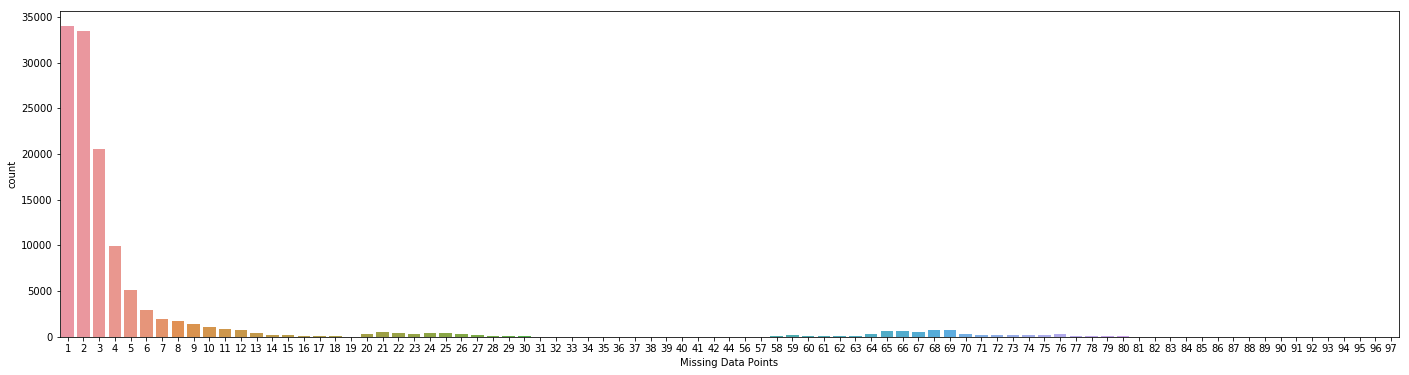

In [33]:
#missingrowdata

plt.figure(figsize=(24,6))
ax = sns.countplot(missingrowdata[(missingrowdata>0) & (missingrowdata<100)])
ax.set_xlabel('Missing Data Points')

plt.show()

Observation:  <br>
For Azdiaz Dataset: <br>
From the above calculation, it seems that if we want to split the data into 2 subset (1 with high missing data points and 1 with lower missing data points), we can choose a cutoff point at 225. This will make the set of data with lower missing data points to contain more than 90% of total available data. However, a dataset with 225 missing data points in a row from a total of 360 data points would be too high a number (62%) . Hence, I will choose a threshold of 25 as the cutoff to split the data into set for lower missing data points. This set of data will contained 82% of total available data, and that 25 missing datapoints from a total of ~360 datapoints in a row is ~7% which is relatively not that high.

For Customer Dataset: <br>
I will choose a threshold of 35 after running the customer dataset with the similar reasons



In [46]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias['nan_row'] = azdias.isnull().sum(axis=1) # count the null for each row
#missingrowdata['nan_row'] = azdias.isnull().sum(axis=1).sort_values(ascending=False)

#print(missingrowdata.head())

threshold = 25 # For Azdias
#threshold = 35 # For Customer dataset

#low_or_no_nanrow_azdias = azdias.loc[missingrowdata['nan_row'] <= threshold, :]
#high_nanrow_azdias = azdias.loc[missingrowdata['nan_row'] > threshold, :]

low_or_no_nanrow_azdias = azdias.loc[azdias['nan_row'] <= threshold, :] 
high_nanrow_azdias = azdias.loc[azdias['nan_row'] > threshold, :]

#print(low_or_no_nanrow_azdias.shape)
#print(high_nanrow_azdias.shape)

low_or_no_nanrow_azdias = low_or_no_nanrow_azdias.drop('nan_row', axis=1)
high_nanrow_azdias = high_nanrow_azdias.drop('nan_row', axis=1)

print('low_or_no_nanrow_azdias: ' + str(low_or_no_nanrow_azdias.shape))
print('high_nanrow_azdias: ' + str(high_nanrow_azdias.shape))
#print(low_or_no_nanrow_azdias.head())

zero_nanrow_azdias = azdias.loc[azdias['nan_row'] == 0, :]
zero_nanrow_azdias = zero_nanrow_azdias.drop('nan_row', axis=1)
print ('zero_nanrow_azdias: ' + str(zero_nanrow_azdias.shape))

azdias = azdias.drop('nan_row', axis=1)

print('Count of Row with [>=1, <=100] missing data points in a row: ' +  str(low_or_no_nanrow_azdias.shape[0] - zero_nanrow_azdias.shape[0]))

low_or_no_nanrow_azdias: (82542, 359)
high_nanrow_azdias: (17469, 359)
zero_nanrow_azdias: (2204, 359)
Count of Row with [>=1, <=100] missing data points in a row: 80338


In [44]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols_wo_missingvalues_lownanwow = low_or_no_nanrow_azdias.dropna(axis=1).columns
#print(cols_wo_missingvalues_lownanwow)
cols_wo_missingvalues_highnanrow  = high_nanrow_azdias.dropna(axis=1).columns
#print(cols_wo_missingvalues_highnanrow)

xcols = cols_wo_missingvalues_lownanwow.intersection(cols_wo_missingvalues_highnanrow)
#print(xcols)
xcols = list(xcols)
print(xcols)

['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND

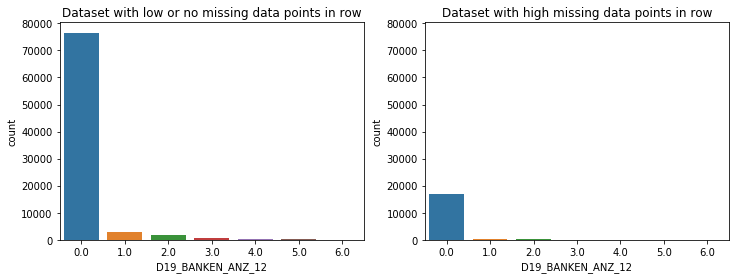

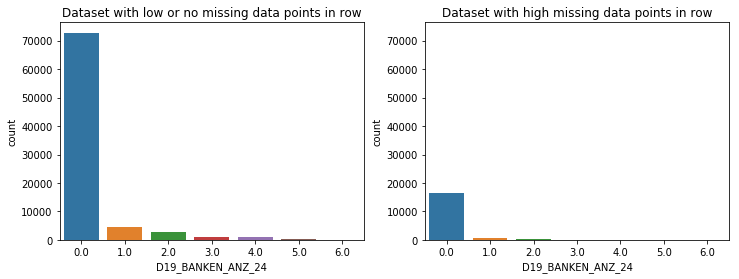

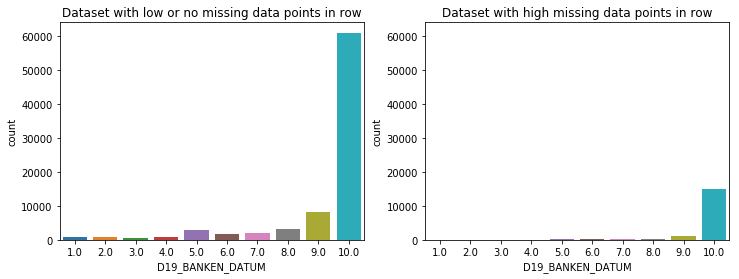

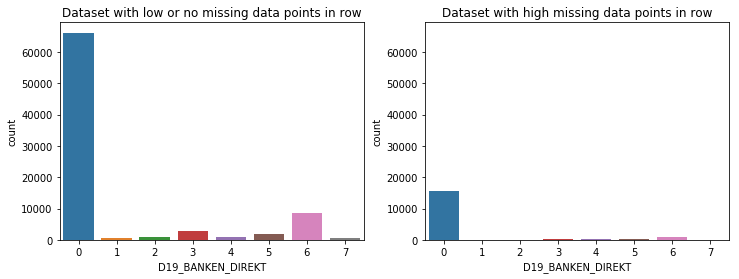

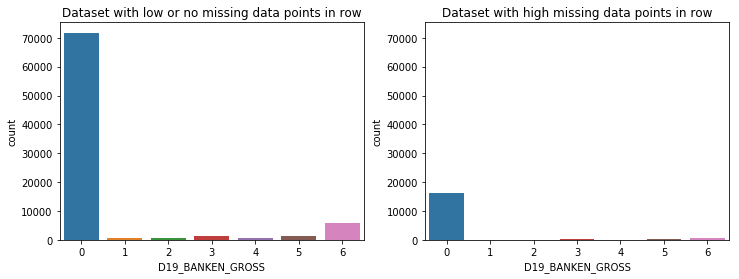

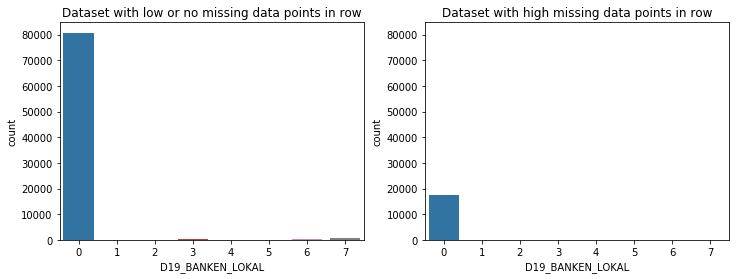

In [46]:
def compare_distribution(colname):
    fig, ax = plt.subplots(1,2, figsize=(12, 4))
    ax1 = plt.subplot(1,2,1)
    ax1.set_title('Dataset with low or no missing data points in row')
    ax1 = sns.countplot(low_or_no_nanrow_azdias[colname])
    ax2 = plt.subplot(1,2,2, sharey = ax1)
    ax2.set_title('Dataset with high missing data points in row')
    ax2 = sns.countplot(high_nanrow_azdias[colname])
    plt.show()
    

for col in xcols[:6]:
    compare_distribution(col)

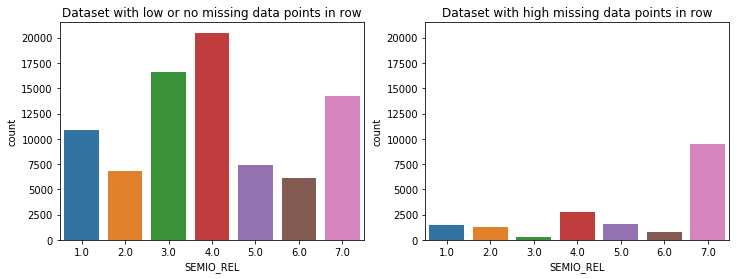

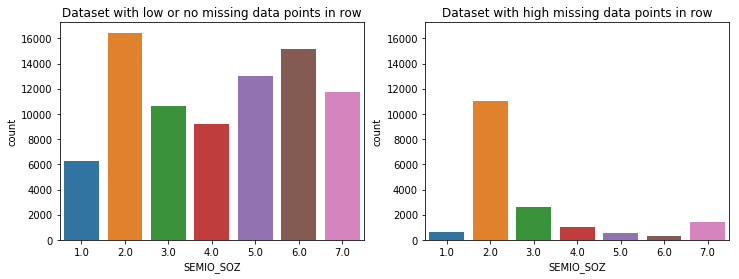

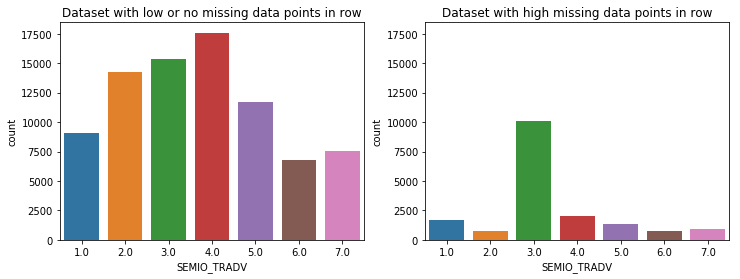

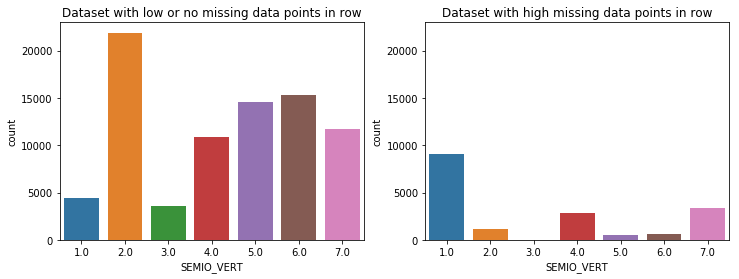

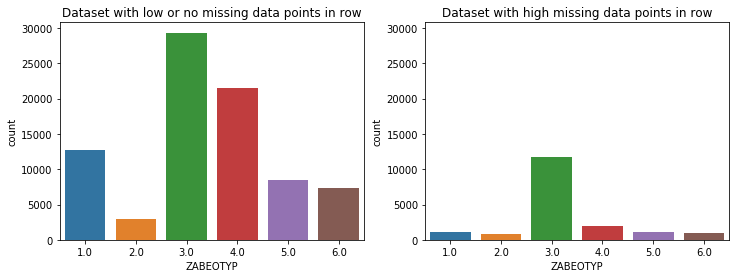

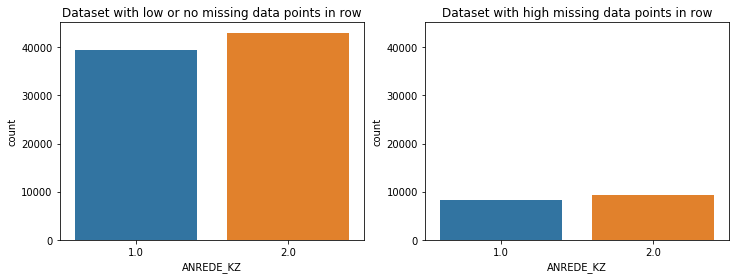

In [47]:
for col in xcols[-6:]:
    compare_distribution(col)

Comparing the 2 subset of data (dataset with high missing datapoints vs dataset with low_or_no missing datapoints) particularly on the 6 intersect columns that has no missing data points for both, it seems that some of them have similar distribution and some of them peak at certain value (dataset with high missing datapoints) such as SEMIO_SOZ, but the dataset with low_or_no missing datapoints also is the highest for that particular value. There could be some qualitative difference but might not be extremely significant.

Hence, I will choose to drop the dataset with high missing datapoints from the analysis (not at this juncture). <b> However, please take note that I choosed to process the whole azdias dataset in subsequent steps and will only applied/rerun this (drop missing rows above threshold) steps before running my Data Imputation. </b> In other words, this <b>Step 1.1.3: Assess Missing Data in Each Row </b> section was being performed early just to check things up.





### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [43]:
# How many features are there of each data type?
#print(feat_info.head())
print(feat_info.type.value_counts())
print (feat_info.shape, '\n')

new_feat_info = feat_info[feat_info.attribute.isin(azdias.columns)]
print(new_feat_info.type.value_counts())
print (new_feat_info.shape)

ordinal        243
categorical     24
numeric          7
mixed            7
interval         1
Name: type, dtype: int64
(282, 4) 

ordinal        243
categorical     23
numeric          7
mixed            7
interval         1
Name: type, dtype: int64
(281, 4)


#### Step 1.2.1: Re-Encode Categorical Features
For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:

- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. 

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

new_feat_info = feat_info[feat_info.attribute.isin(azdias.columns)]
new_feat_info[new_feat_info.type == 'categorical']
cols_categorical = new_feat_info[new_feat_info.type == 'categorical'].attribute

print(cols_categorical, '\n')

print('Unique value of Categorical Columns:')
categorical_azdias = azdias[cols_categorical].nunique().sort_values() #This is the set with dropped columns

categorical_azdias

0              AGER_TYP
2             ANREDE_KZ
3         CJT_GESAMTTYP
10            FINANZTYP
12      GFK_URLAUBERTYP
13     GREEN_AVANTGARDE
17      LP_FAMILIE_FEIN
18      LP_FAMILIE_GROB
19       LP_STATUS_FEIN
20       LP_STATUS_GROB
21     NATIONALITAET_KZ
38          SHOPPER_TYP
39              SOHO_KZ
41             VERS_TYP
42             ZABEOTYP
47         KK_KUNDENTYP
52          GEBAEUDETYP
55          OST_WEST_KZ
57      CAMEO_DEUG_2015
58       CAMEO_DEU_2015
89          STRUKTURTYP
121      KBA05_MAXHERST
258       D19_KONSUMTYP
Name: attribute, dtype: object 

Unique value of Categorical Columns:


ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
GREEN_AVANTGARDE     2
SOHO_KZ              2
AGER_TYP             3
STRUKTURTYP          3
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
KBA05_MAXHERST       5
ZABEOTYP             6
KK_KUNDENTYP         6
GEBAEUDETYP          6
FINANZTYP            6
CJT_GESAMTTYP        6
D19_KONSUMTYP        7
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEUG_2015     18
CAMEO_DEU_2015      44
dtype: int64

In [45]:
print('Categorical Columns of binary value:')

print((azdias[cols_categorical].nunique() == 2).sum())
categorical_azdias[categorical_azdias==2]

Categorical Columns of binary value:
5


ANREDE_KZ           2
OST_WEST_KZ         2
VERS_TYP            2
GREEN_AVANTGARDE    2
SOHO_KZ             2
dtype: int64

In [46]:
print('Categorical Columns of multilevel variables:')

print((azdias[cols_categorical].nunique() > 2).sum())
categorical_azdias[categorical_azdias > 2]

Categorical Columns of multilevel variables:
18


AGER_TYP             3
STRUKTURTYP          3
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
KBA05_MAXHERST       5
ZABEOTYP             6
KK_KUNDENTYP         6
GEBAEUDETYP          6
FINANZTYP            6
CJT_GESAMTTYP        6
D19_KONSUMTYP        7
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEUG_2015     18
CAMEO_DEU_2015      44
dtype: int64

In [47]:
print('Types of Categorical Columns:')

print(azdias[cols_categorical].dtypes)

azdias[cols_categorical[:]].head()

Types of Categorical Columns:
AGER_TYP            float64
ANREDE_KZ           float64
CJT_GESAMTTYP       float64
FINANZTYP           float64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE    float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP            float64
KK_KUNDENTYP        float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
STRUKTURTYP         float64
KBA05_MAXHERST      float64
D19_KONSUMTYP       float64
dtype: object


,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,...,VERS_TYP,ZABEOTYP,KK_KUNDENTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,STRUKTURTYP,KBA05_MAXHERST,D19_KONSUMTYP
0,2.0,2.0,2.0,6.0,1.0,0.0,NaN,NaN,9.0,4.0,...,1.0,3.0,NaN,1.0,W,2,2A,1.0,3.0,9.0
1,NaN,2.0,4.0,1.0,12.0,1.0,1.0,1.0,3.0,2.0,...,2.0,4.0,6.0,3.0,W,1,1E,3.0,1.0,3.0
2,NaN,1.0,6.0,3.0,10.0,0.0,5.0,3.0,9.0,4.0,...,1.0,1.0,3.0,1.0,W,6,6B,3.0,NaN,1.0
3,NaN,2.0,6.0,1.0,11.0,0.0,1.0,1.0,8.0,4.0,...,1.0,4.0,NaN,1.0,W,4,4C,3.0,2.0,NaN
4,NaN,1.0,3.0,3.0,2.0,0.0,1.0,1.0,8.0,4.0,...,1.0,1.0,6.0,1.0,W,NaN,NaN,3.0,NaN,4.0


In [48]:
# Re-encode categorical variable(s) but with object type to be kept in the analysis.

print(azdias['OST_WEST_KZ'].value_counts())

#low_or_no_nanrow_azdias.loc[:, 'OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
#high_nanrow_azdias.loc[:, 'OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
azdias.loc[:, 'OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)

#print(low_or_no_nanrow_azdias['OST_WEST_KZ'].value_counts())
#print(high_nanrow_azdias['OST_WEST_KZ'].value_counts())
print(azdias['OST_WEST_KZ'].value_counts())

W    70563
O    18941
Name: OST_WEST_KZ, dtype: int64
1.0    70563
0.0    18941
Name: OST_WEST_KZ, dtype: int64


##### Re-Encode Categorical Features  Discussion
From the list of categorical columns, 5 of the columns are binary so I have to keep them, but there is one binary variable that takes on non-numeric values which is OST_WEST_KZ. For this one, I have re-encode the values as numbers. 

The engineering step that performed against non-numerical value of OST_WEST_KZ is to convert it to binary variable by: 'W' maps to 1 'O' maps to 0

In [49]:
# Re-encode categorical variable(s) but with object type to be kept in the analysis.

print(azdias['CAMEO_DEUG_2015'].unique())

#Looks like there are some number being stored as str. Convert them all to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float')

print(azdias['CAMEO_DEUG_2015'].unique())



[2.0 1.0 6.0 4.0 nan 9.0 3.0 7.0 5.0 8.0 '3' '6' '8' '7' '4' '9' '2' '1'
 '5']
[ 2.  1.  6.  4. nan  9.  3.  7.  5.  8.]


In [50]:
# Re-encode categorical variable(s) but with object type to be kept in the analysis.

#print(azdias['CAMEO_DEU_2015'].value_counts())
print(azdias['CAMEO_DEU_2015'].unique())

labels = azdias['CAMEO_DEU_2015'].dropna().unique().tolist()
labels.sort()
#print(labels)

cameo_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
print(cameo_mapping)

azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].map(cameo_mapping)
print(azdias['CAMEO_DEU_2015'].unique())

['2A' '1E' '6B' '4C' nan '9B' '3C' '7A' '3D' '5C' '7D' '4A' '1D' '6A' '2B'
 '5D' '1A' '8D' '4E' '8A' '2C' '8B' '6C' '4B' '3A' '9D' '2D' '3B' '9A'
 '7B' '8C' '6E' '6D' '9C' '7C' '6F' '5B' '9E' '4D' '5F' '7E' '5A' '1B'
 '1C' '5E']
{'1A': 1, '1B': 2, '1C': 3, '1D': 4, '1E': 5, '2A': 6, '2B': 7, '2C': 8, '2D': 9, '3A': 10, '3B': 11, '3C': 12, '3D': 13, '4A': 14, '4B': 15, '4C': 16, '4D': 17, '4E': 18, '5A': 19, '5B': 20, '5C': 21, '5D': 22, '5E': 23, '5F': 24, '6A': 25, '6B': 26, '6C': 27, '6D': 28, '6E': 29, '6F': 30, '7A': 31, '7B': 32, '7C': 33, '7D': 34, '7E': 35, '8A': 36, '8B': 37, '8C': 38, '8D': 39, '9A': 40, '9B': 41, '9C': 42, '9D': 43, '9E': 44}
[ 6.  5. 26. 16. nan 41. 12. 31. 13. 21. 34. 14.  4. 25.  7. 22.  1. 39.
 18. 36.  8. 37. 27. 15. 10. 43.  9. 11. 40. 32. 38. 29. 28. 42. 33. 30.
 20. 44. 17. 24. 35. 19.  2.  3. 23.]


<b> Step 1.2.2: Engineer Mixed-Type Features found and described in feature summary  </b>

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; 

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [51]:
pd.set_option('display.max_rows', 500)

cols_mixed = feat_info[feat_info.type == 'mixed'].attribute
print(cols_mixed, '\n')

print('Unique value of mixed Columns:')
mixed_azdias = azdias[cols_mixed].nunique().sort_values() 
mixed_azdias

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object 

Unique value of mixed Columns:


KBA05_BAUMAX              5
PLZ8_BAUMAX               5
WOHNLAGE                  8
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
LP_LEBENSPHASE_FEIN      40
CAMEO_INTL_2015          42
dtype: int64

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())
#print (low_or_no_nanrow_azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())

'''
Code for Decade:
1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s

Code for Movement:
1: Mainstream
2: Avantgarde

'''

decade_mapping = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_mapping = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}


#low_or_no_nanrow_azdias['Decade'] = low_or_no_nanrow_azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
#high_nanrow_azdias['Decade'] = high_nanrow_azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

#low_or_no_nanrow_azdias['Movement'] = low_or_no_nanrow_azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
#high_nanrow_azdias['Movement'] = high_nanrow_azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)


#print (low_or_no_nanrow_azdias['Decade'].value_counts())
#print (low_or_no_nanrow_azdias['Movement'].value_counts())
print (azdias['Decade'].value_counts())
print (azdias['Movement'].value_counts())

#print(low_or_no_nanrow_azdias.shape)
#print(high_nanrow_azdias.shape)
print(azdias.shape)

cols_to_remove.append('PRAEGENDE_JUGENDJAHRE')


14.0    21130
8.0     16357
5.0      9655
10.0     9594
3.0      6297
15.0     4739
11.0     3973
9.0      3781
6.0      2916
12.0     2840
1.0      2358
4.0      2280
2.0       811
13.0      644
7.0       486
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
6.0    25869
4.0    20138
5.0    17051
3.0    13057
2.0     8577
1.0     3169
Name: Decade, dtype: int64
1.0    68231
2.0    19630
Name: Movement, dtype: int64
(100011, 362)


In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

print (azdias['CAMEO_INTL_2015'].value_counts())
print (azdias['CAMEO_INTL_2015'].isnull().sum())


'''
Code for Household Wealth:
1: Wealthy Households
2: Prosperous Households
3: Comfortable Households
4: Less Affluent Households
5: Poorer Households

Code for Life Stage of a person:
1: Pre-Family Couples & Singles
2: Young Couples With Children
3: Families With School Age Children
4: Older Families &  Mature Couples
5: Elders In Retirement

'''


def split_code_For_wealth(x):
    if not pd.isna(x):
        return int(str(x)[0])
    return np.nan

def split_code_For_lifestage(x):
    if not pd.isna(x):
        return int(str(x)[1])
    return np.nan


#df_low_azdias['Wealth'] = df_low_azdias['CAMEO_INTL_2015'].apply(split_code_For_wealth)
#df_high_azdias['Wealth'] = df_high_azdias['CAMEO_INTL_2015'].apply(split_code_For_wealth)

#df_low_azdias['Life_Stage'] = df_low_azdias['CAMEO_INTL_2015'].apply(split_code_For_lifestage)
#df_high_azdias['Life_Stage'] = df_high_azdias['CAMEO_INTL_2015'].apply(split_code_For_lifestage)

azdias['Wealth'] = azdias['CAMEO_INTL_2015'].apply(split_code_For_wealth)
azdias['Life_Stage'] = azdias['CAMEO_INTL_2015'].apply(split_code_For_lifestage)

print (azdias['Wealth'].value_counts())
print (azdias['Life_Stage'].value_counts())
print (azdias.shape)

cols_to_remove.append('CAMEO_INTL_2015')

51      10444
41       7164
24       6997
14       4902
51.0     4612
43       4451
54       3585
24.0     3132
41.0     3099
25       3027
22       2536
14.0     2118
13       2107
23       2104
43.0     1997
45       1988
55       1833
52       1587
54.0     1584
31       1446
25.0     1436
34       1419
15       1273
22.0     1168
44       1104
12       1002
13.0      993
23.0      935
45.0      896
55.0      876
32        836
33        776
35        773
31.0      688
52.0      681
34.0      643
15.0      589
44.0      507
12.0      455
35.0      365
32.0      356
33.0      325
Name: CAMEO_INTL_2015, dtype: int64
11202
5.0    25202
2.0    21335
4.0    21206
1.0    13439
3.0     7627
Name: Wealth, dtype: int64
1.0    27453
4.0    25991
3.0    13688
5.0    13056
2.0     8621
Name: Life_Stage, dtype: int64
(100011, 365)


In [53]:
print(azdias['LP_FAMILIE_GROB'].isnull().sum())
print(azdias['LP_STATUS_GROB'].isnull().sum())
print(azdias['LP_LEBENSPHASE_FEIN'].isnull().sum())

8762
552
10946


In [54]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_FEIN.unique())
print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())

[nan  1.  5.  7. 10.  2. 11.  8.  4.  6.  9.  3.]
[nan  1.  3.  4.  5.  2.]
[ 9.  3.  8. 10.  4.  1.  7.  2. nan  5.  6.]
[ 4.  2.  5.  1.  3. nan]
[nan  4. 23. 10. 11. 25. 13.  7.  2. 29. 20. 39. 32. 36.  1. 35. 24.  6.
  5. 21. 30. 34. 27.  8. 28. 31. 37. 15. 40. 38.  3. 12.  9. 33. 26. 19.
 14. 16. 18. 22. 17.]
[nan  1.  6.  3.  7.  2.  9.  5. 12. 10. 11.  8.  4.]


In [55]:
# Investigate "LP_LEBENSPHASE_FEIN" and engineer new variables.
# Investigate ("LP_LEBENSPHASE_FEIN" || "LP_LEBENSPHASE_GROB"), ("LP_FAMILIE_GROB" || "LP_FAMILIE_FEIN"), 
# ("LP_STATUS_GROB" || "LP_STATUS_FEIN")
# It seems that these few features have to look side-by-side

'''
After looking at their values, I decided 

1) to drop "LP_FAMILIE_FEIN" and keep "LP_FAMILIE_GROB" - as "_FEIN" is too fine/detail of an information/category
2) to drop "LP_STATUS_FEIN" and keep "LP_STATUS_GROB".
3) to drop "LP_LEBENSPHASE_GROB" and "LP_LEBENSPHASE_FEIN", but re-engineer "LP_LEBENSPHASE_FEIN" to extract the Age Group which
    are not available thru "LP_FAMILIE_GROB" & "LP_STATUS_GROB". 
    This is because "LP_LEBENSPHASE_FEIN" has 3 parts of information - FamilyStatus, Income, AgeGroup. The first 2 parts are 
    categorized and available thru "LP_FAMILIE_GROB" and "LP_STATUS_GROB" respectively. 

'''

#print(azdias['LP_LEBENSPHASE_FEIN'].value_counts())
#print(azdias['LP_LEBENSPHASE_GROB'].value_counts())
#azdias.groupby(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"]).size()
#azdias.groupby(["LP_LEBENSPHASE_FEIN", "LP_FAMILIE_GROB"]).size()
#azdias.groupby(["LP_LEBENSPHASE_FEIN", "LP_STATUS_GROB"]).size()
#azdias.groupby(["LP_LEBENSPHASE_GROB", "LP_STATUS_GROB", "LP_FAMILIE_GROB"]).size()

#cols_to_remove = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB']
#azdias = azdias.drop(cols_to_remove, axis=1)


'''
Code for FamilyStatus:
1: Single
2: Couple
3: SingleParent
4: Family
5: MultipersonHousehold

Code for Income :
1: LowIncomeEarners
2: AverageEarners
3: Independants
4: HouseOwners
5: TopEarners

Code for Age Group:
1: YoungerAge
2: MiddleAge
3: Higher/AdvancedAge 
4: RetirementAge

'''

#It seems that LP_FAMILIE_GROB and LP_STATUS_GROB are already in the range of 1 - 5. There are no mapping needed. 

#Family_mapping = {1:1, 2:2, 3:3, 4:3, 5:3, 6:4, 7:4, 8:4, 9:5, 10:5, 11:5}

#Income_mapping = {1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5}

AgeGroup_mapping = {1:1, 2:2, 3:1, 4:2, 5:3, 6:4, 7:3, 8:4, 9:2, 10:2, 11:3, 12:4, 13:3, 14:1, 15:3,
                    16:3, 17:2, 18:1, 19:3, 20:3, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1,
                    31:3, 32:3, 33:1, 34:3, 35:1, 36:3, 37:3, 38:4, 39:2, 40:4}


#azdias['LP_FAMILIE_GROB'] = azdias['LP_FAMILIE_GROB'].map(Family_mapping)

#azdias['LP_STATUS_GROB'] = azdias['LP_STATUS_GROB'].map(Income_mapping)

azdias['LP_LEBENSPHASE_FEIN_AgeGroup'] = azdias['LP_LEBENSPHASE_FEIN'].map(AgeGroup_mapping)




cols_to_remove.extend(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'])


In [56]:
print(azdias['LP_FAMILIE_GROB'].isnull().sum())
print(azdias['LP_STATUS_GROB'].isnull().sum())
print(azdias['LP_LEBENSPHASE_FEIN'].isnull().sum())

8762
552
10946


In [57]:
#print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())

#print(azdias.LP_STATUS_FEIN.unique())
print(azdias.LP_STATUS_GROB.unique())

#print(azdias.LP_LEBENSPHASE_FEIN.unique())
#print(azdias.LP_LEBENSPHASE_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN_AgeGroup.unique())

[nan  1.  3.  4.  5.  2.]
[ 4.  2.  5.  1.  3. nan]
[nan  2.  3.  1.  4.]


In [58]:
# Investigate "WOHNLAGE" and fix

print(azdias.WOHNLAGE.unique())

azdias['WOHNLAGE'] = azdias['WOHNLAGE'].replace({0: np.NaN})

print(azdias.WOHNLAGE.unique())

[ 7.  3.  2. nan  4.  1.  5.  0.  8.]
[ 7.  3.  2. nan  4.  1.  5.  8.]


In [60]:
# Investigate "KBA05_BAUMAX" and fix

print(azdias.KBA05_BAUMAX.unique())
azdias['KBA05_BAUMAX'] = azdias['KBA05_BAUMAX'].replace({0: np.NaN})
print(azdias.KBA05_BAUMAX.unique())
#Looks like all good


[ 1. nan  3.  5.  4.  2.]
[ 1. nan  3.  5.  4.  2.]


In [61]:
# Investigate "PLZ8_BAUMAX" and fix

print(azdias.PLZ8_BAUMAX.unique())
azdias['PLZ8_BAUMAX'] = azdias['PLZ8_BAUMAX'].replace({0: np.NaN})
print(azdias.PLZ8_BAUMAX.unique())

#Looks like all good

[ 1. nan  4.  3.  5.  2.]
[ 1. nan  4.  3.  5.  2.]


In [65]:
print(azdias.shape)

(100011, 365)


In [66]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Decade,Movement,LP_LEBENSPHASE_FEIN_AgeGroup,Wealth,Life_Stage
0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3.0,2.0,4.0,4.0,1.0,NaN,1.0,2.0
1,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,...,3.0,7.0,4.0,2.0,3.0,6.0,2.0,2.0,1.0,5.0
2,NaN,5.0,21.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,...,4.0,3.0,1.0,1.0,3.0,4.0,1.0,2.0,4.0,3.0
3,NaN,9.0,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,...,5.0,2.0,4.0,2.0,2.0,5.0,1.0,2.0,2.0,4.0
4,NaN,1.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,...,3.0,7.0,1.0,1.0,3.0,4.0,1.0,3.0,NaN,NaN


In [67]:
print(cols_to_remove)
cols_to_remove = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']
print(cols_to_remove)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ', 'LNR', 'PRAEGENDE_JUGENDJAHRE', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'CAMEO_INTL_2015']
['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']


In [68]:
#Drop selected mixed type columns
print(azdias.shape)
azdias = azdias.drop(cols_to_remove, axis=1)
print(azdias.shape)

(100011, 365)
(100011, 359)


#### Step 1.2.2: Handle misc Features

There are some columns which are not describe in the feat_info and we don't know what they are. We will try our best to preserve them.

In [69]:
print('Types of Columns:')
all_cols = azdias.columns.tolist()

pd.set_option('display.max_rows', 500)

print(azdias[all_cols].dtypes)

azdias[all_cols[:]].head()

Types of Columns:
AGER_TYP                        float64
AKT_DAT_KL                      float64
ALTER_HH                        float64
ALTERSKATEGORIE_FEIN            float64
ANZ_HAUSHALTE_AKTIV             float64
ANZ_HH_TITEL                    float64
ANZ_KINDER                      float64
ANZ_PERSONEN                    float64
ANZ_STATISTISCHE_HAUSHALTE      float64
ANZ_TITEL                       float64
ARBEIT                          float64
BALLRAUM                        float64
CAMEO_DEU_2015                  float64
CAMEO_DEUG_2015                 float64
CJT_GESAMTTYP                   float64
CJT_KATALOGNUTZER               float64
CJT_TYP_1                       float64
CJT_TYP_2                       float64
CJT_TYP_3                       float64
CJT_TYP_4                       float64
CJT_TYP_5                       float64
CJT_TYP_6                       float64
D19_BANKEN_ANZ_12               float64
D19_BANKEN_ANZ_24               float64
D19_BANKEN_DATUM      

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Decade,Movement,LP_LEBENSPHASE_FEIN_AgeGroup,Wealth,Life_Stage
0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3.0,2.0,4.0,4.0,1.0,NaN,1.0,2.0
1,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,...,3.0,7.0,4.0,2.0,3.0,6.0,2.0,2.0,1.0,5.0
2,NaN,5.0,21.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,...,4.0,3.0,1.0,1.0,3.0,4.0,1.0,2.0,4.0,3.0
3,NaN,9.0,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,...,5.0,2.0,4.0,2.0,2.0,5.0,1.0,2.0,2.0,4.0
4,NaN,1.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,...,3.0,7.0,1.0,1.0,3.0,4.0,1.0,3.0,NaN,NaN


In [70]:
azdias.select_dtypes(include=['object']).columns

Index(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], dtype='object')

In [71]:
# Column D19_LETZTER_KAUF_BRANCHE has no information in the feature summary.

azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

array(['D19_UNBEKANNT', 'D19_KOSMETIK', 'D19_SCHUHE', nan, 'D19_ENERGIE',
       'D19_BANKEN_GROSS', 'D19_VERSICHERUNGEN', 'D19_SONSTIGE',
       'D19_BANKEN_DIREKT', 'D19_VOLLSORTIMENT', 'D19_TELKO_REST',
       'D19_BUCH_CD', 'D19_VERSAND_REST', 'D19_DROGERIEARTIKEL',
       'D19_HAUS_DEKO', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_REST',
       'D19_DIGIT_SERV', 'D19_GARTEN', 'D19_TELKO_MOBILE', 'D19_HANDWERK',
       'D19_NAHRUNGSERGAENZUNG', 'D19_FREIZEIT', 'D19_TIERARTIKEL',
       'D19_WEIN_FEINKOST', 'D19_LEBENSMITTEL', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_TECHNIK', 'D19_BILDUNG',
       'D19_KINDERARTIKEL', 'D19_BANKEN_LOKAL', 'D19_SAMMELARTIKEL',
       'D19_BIO_OEKO', 'D19_LOTTO'], dtype=object)

In [72]:
# Re-encode categorical variable(s) but with object type to be kept in the analysis.


print(azdias['D19_LETZTER_KAUF_BRANCHE'].unique())

labels = azdias['D19_LETZTER_KAUF_BRANCHE'].dropna().unique().tolist()
labels.sort()
#print(labels)

BRANCHE_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
print(BRANCHE_mapping)

azdias['D19_LETZTER_KAUF_BRANCHE'] = azdias['D19_LETZTER_KAUF_BRANCHE'].map(BRANCHE_mapping)
print(azdias['D19_LETZTER_KAUF_BRANCHE'].unique())




['D19_UNBEKANNT' 'D19_KOSMETIK' 'D19_SCHUHE' nan 'D19_ENERGIE'
 'D19_BANKEN_GROSS' 'D19_VERSICHERUNGEN' 'D19_SONSTIGE'
 'D19_BANKEN_DIREKT' 'D19_VOLLSORTIMENT' 'D19_TELKO_REST' 'D19_BUCH_CD'
 'D19_VERSAND_REST' 'D19_DROGERIEARTIKEL' 'D19_HAUS_DEKO'
 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_REST' 'D19_DIGIT_SERV' 'D19_GARTEN'
 'D19_TELKO_MOBILE' 'D19_HANDWERK' 'D19_NAHRUNGSERGAENZUNG' 'D19_FREIZEIT'
 'D19_TIERARTIKEL' 'D19_WEIN_FEINKOST' 'D19_LEBENSMITTEL' 'D19_REISEN'
 'D19_BEKLEIDUNG_GEH' 'D19_RATGEBER' 'D19_TECHNIK' 'D19_BILDUNG'
 'D19_KINDERARTIKEL' 'D19_BANKEN_LOKAL' 'D19_SAMMELARTIKEL' 'D19_BIO_OEKO'
 'D19_LOTTO']
{'D19_BANKEN_DIREKT': 1, 'D19_BANKEN_GROSS': 2, 'D19_BANKEN_LOKAL': 3, 'D19_BANKEN_REST': 4, 'D19_BEKLEIDUNG_GEH': 5, 'D19_BEKLEIDUNG_REST': 6, 'D19_BILDUNG': 7, 'D19_BIO_OEKO': 8, 'D19_BUCH_CD': 9, 'D19_DIGIT_SERV': 10, 'D19_DROGERIEARTIKEL': 11, 'D19_ENERGIE': 12, 'D19_FREIZEIT': 13, 'D19_GARTEN': 14, 'D19_HANDWERK': 15, 'D19_HAUS_DEKO': 16, 'D19_KINDERARTIKEL': 17, 'D19_KOSM

In [73]:
# Column EINGEFUEGT_AM can be converted to datetime

print(azdias['EINGEFUEGT_AM'].unique())

azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])
azdias['EINGEFUEGT_AM'] = azdias['EINGEFUEGT_AM'].dt.year

print(azdias['EINGEFUEGT_AM'].unique())

['1997-04-21 00:00:00' '1992-02-10 00:00:00' '2005-12-30 00:00:00' ...
 '2002-10-15 00:00:00' '2001-03-13 00:00:00' '2015-08-14 00:00:00']
[1997. 1992. 2005. 1996. 2015.   nan 1995. 1993. 2004. 1994. 2007. 2003.
 2009. 2013. 2012. 2011. 2002. 1998. 2008. 2000. 2010. 1999. 2006. 2014.
 2001. 2016. 1991.]


In [74]:
%%time
# Convert int cols to float
for col in azdias.columns:
    if azdias[col].dtype == np.int64:
        azdias[col] = azdias[col].astype(np.float64)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 142 ms


In [75]:
print('Types of Columns:')
all_cols = azdias.columns.tolist()

pd.set_option('display.max_rows', 500)

print(azdias[all_cols].dtypes)


Types of Columns:
AGER_TYP                        float64
AKT_DAT_KL                      float64
ALTER_HH                        float64
ALTERSKATEGORIE_FEIN            float64
ANZ_HAUSHALTE_AKTIV             float64
ANZ_HH_TITEL                    float64
ANZ_KINDER                      float64
ANZ_PERSONEN                    float64
ANZ_STATISTISCHE_HAUSHALTE      float64
ANZ_TITEL                       float64
ARBEIT                          float64
BALLRAUM                        float64
CAMEO_DEU_2015                  float64
CAMEO_DEUG_2015                 float64
CJT_GESAMTTYP                   float64
CJT_KATALOGNUTZER               float64
CJT_TYP_1                       float64
CJT_TYP_2                       float64
CJT_TYP_3                       float64
CJT_TYP_4                       float64
CJT_TYP_5                       float64
CJT_TYP_6                       float64
D19_BANKEN_ANZ_12               float64
D19_BANKEN_ANZ_24               float64
D19_BANKEN_DATUM      

In [76]:
new_feat_info = feat_info[feat_info.attribute.isin(azdias.columns)]
new_feat_info[new_feat_info.type == 'categorical']
cols_categorical = new_feat_info[new_feat_info.type == 'categorical'].attribute

print(cols_categorical, '\n')

print('Unique value of Categorical Columns:')
categorical_azdias = azdias[cols_categorical].nunique().sort_values() #This is the set with dropped columns

categorical_azdias

print((azdias[cols_categorical].nunique() > 2).sum())

categorical_azdias[categorical_azdias > 2]

0              AGER_TYP
2             ANREDE_KZ
3         CJT_GESAMTTYP
10            FINANZTYP
12      GFK_URLAUBERTYP
13     GREEN_AVANTGARDE
18      LP_FAMILIE_GROB
20       LP_STATUS_GROB
21     NATIONALITAET_KZ
38          SHOPPER_TYP
39              SOHO_KZ
41             VERS_TYP
42             ZABEOTYP
47         KK_KUNDENTYP
52          GEBAEUDETYP
55          OST_WEST_KZ
57      CAMEO_DEUG_2015
58       CAMEO_DEU_2015
89          STRUKTURTYP
121      KBA05_MAXHERST
258       D19_KONSUMTYP
Name: attribute, dtype: object 

Unique value of Categorical Columns:
16


STRUKTURTYP          3
NATIONALITAET_KZ     3
AGER_TYP             3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
KBA05_MAXHERST       5
LP_STATUS_GROB       5
ZABEOTYP             6
KK_KUNDENTYP         6
GEBAEUDETYP          6
FINANZTYP            6
CJT_GESAMTTYP        6
D19_KONSUMTYP        7
CAMEO_DEUG_2015      9
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

<b> Step 1.2.3 Impute Missing Values NaN  </b> 

Before Imputing, I want to get rid of rows with high missing datapoints in a rows. <br>
Run the whole Assess Missing Data Analysis section in <b>Step 1.1.3</b> again to re-determine the threshold. Taking the code from <b>Step 1.1.3: Assess Missing Data in Each Row </b> section and split the dataset based on missing datapoints in a row

In [79]:
# Write code to divide the data into two subsets based on the number of missing

print('Processing Missing values in each rows')
threshold = 25
azdias['nan_row'] = azdias.isnull().sum(axis=1) # count the null for each row

low_or_no_nanrow_azdias = azdias.loc[azdias['nan_row'] <= threshold, :] 
high_nanrow_azdias = azdias.loc[azdias['nan_row'] > threshold, :]

low_or_no_nanrow_azdias = low_or_no_nanrow_azdias.drop('nan_row', axis=1)
high_nanrow_azdias = high_nanrow_azdias.drop('nan_row', axis=1)

print('low_or_no_nanrow_azdias: ' + str(low_or_no_nanrow_azdias.shape))
print('high_nanrow_azdias: ' + str(high_nanrow_azdias.shape))


Processing Missing values in each rows
low_or_no_nanrow_azdias: (82387, 359)
high_nanrow_azdias: (17624, 359)


In [9]:
low_or_no_nanrow_azdias.isnull().sum().sum()

506318

In [82]:
low_or_no_nanrow_azdias.to_pickle('azdias.pkl')

In [83]:
low_or_no_nanrow_azdias = pd.read_pickle('azdias.pkl')

In [19]:
low_or_no_nanrow_azdias.isnull().sum().sum()

506318

In [85]:
low_or_no_nanrow_azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Decade,Movement,LP_LEBENSPHASE_FEIN_AgeGroup,Wealth,Life_Stage
0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3.0,2.0,4.0,4.0,1.0,NaN,1.0,2.0
1,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,...,3.0,7.0,4.0,2.0,3.0,6.0,2.0,2.0,1.0,5.0
3,NaN,9.0,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,...,5.0,2.0,4.0,2.0,2.0,5.0,1.0,2.0,2.0,4.0
5,NaN,6.0,16.0,16.0,6.0,0.0,1.0,2.0,4.0,0.0,...,3.0,3.0,4.0,1.0,3.0,5.0,2.0,2.0,5.0,1.0
6,2.0,1.0,11.0,11.0,1.0,0.0,0.0,1.0,2.0,0.0,...,8.0,3.0,1.0,2.0,4.0,3.0,2.0,3.0,1.0,2.0


In [11]:
low_or_no_nanrow_azdias.shape

(82498, 359)

In [ ]:
%%time
'''
TAKING TOO LONG. NOT USING

# pip install numpy --upgrade --user
# pip install fancyimpute

from workspace_utils import active_session
from fancyimpute import IterativeImputer as MICE

with active_session():
    #using fancyimpute IterativeImputer MICE 
    mice_imputer = MICE()
    df_impute = mice_imputer.fit_transform(low_or_no_nanrow_azdias) 

'''

In [ ]:
%%time
'''
TAKING TOO LONG. NOT USING

with active_session():
    # using Sklearn IterativeImputer MICE 
    mice_imputer = IterativeImputer() 
    # imputing the missing value with mice imputer 
    df_impute = mice_imputer.fit_transform(low_or_no_nanrow_azdias)
    
'''    

In [21]:
%%time

with active_session():
    # using Sklearn SimpleImputer 
    imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
    df_impute = pd.DataFrame(imputer.fit_transform(low_or_no_nanrow_azdias))
    df_impute.columns = low_or_no_nanrow_azdias.columns
    df_impute.index = low_or_no_nanrow_azdias.index
    

CPU times: user 1.49 s, sys: 355 ms, total: 1.84 s
Wall time: 4.71 s


In [ ]:
%%time
'''
TAKING TOO LONG. NOT USING

with active_session():
    # using Sklearn KNNImputer
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    df_impute = imputer.fit_transform(low_or_no_nanrow_azdias)
    
'''


In [23]:
df_impute.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Decade,Movement,Wealth,Life_Stage,LP_LEBENSPHASE_FEIN_AgeGroup
2,2.0,9.0,18.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,...,5.0,2.0,4.0,2.0,2.0,5.0,1.0,2.0,4.0,2.0
3,2.0,9.0,18.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,...,9.0,4.0,4.0,1.0,2.0,5.0,1.0,5.0,5.0,2.0
4,2.0,1.0,20.0,20.0,1.0,0.0,0.0,5.0,1.0,0.0,...,9.0,2.0,2.0,2.0,1.0,6.0,2.0,2.0,5.0,1.0
5,1.0,1.0,16.0,12.0,1.0,0.0,0.0,3.0,1.0,0.0,...,9.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,5.0,4.0
6,2.0,6.0,16.0,16.0,272.0,5.0,0.0,1.0,244.0,0.0,...,8.0,4.0,6.0,1.0,3.0,5.0,2.0,4.0,1.0,2.0


In [22]:
df_impute.isnull().sum().sum()

0

In [24]:
df_impute.to_pickle('azdias.pkl')

<b> Step 1.2.4 Re-encode Multi-Level Categorical Features </b>

In [42]:
azdias = pd.read_pickle('azdias.pkl')

In [43]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0
0,9.0,16.0,16.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,1,0,0,0
2,6.0,16.0,16.0,6.0,0.0,1.0,2.0,4.0,0.0,4.0,...,1,0,0,0,0,1,0,0,0,0
4,9.0,18.0,15.0,9.0,0.0,0.0,1.0,6.0,0.0,3.0,...,1,0,0,0,0,0,1,0,0,0
5,6.0,19.0,19.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,1,0,0,0,0,1,0,0,0,0
6,9.0,18.0,15.0,7.0,0.0,0.0,2.0,7.0,0.0,4.0,...,1,0,0,0,0,0,1,0,0,0


In [30]:
azdias.shape

(82498, 359)

In [31]:
category_features = ['STRUKTURTYP', 'NATIONALITAET_KZ', 'AGER_TYP', 'SHOPPER_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
    'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015', 
    'CAMEO_DEUG_2015', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'WOHNLAGE', 'KBA05_MAXHERST']

print(azdias.shape)
azdias = pd.get_dummies(azdias, columns=category_features)
print(azdias.shape)


(82498, 359)
(82498, 513)


In [32]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0
2,9.0,18.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,9.0,18.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,5.0,...,0,1,0,0,0,0,1,0,0,0
4,1.0,20.0,20.0,1.0,0.0,0.0,5.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,16.0,12.0,1.0,0.0,0.0,3.0,1.0,0.0,4.0,...,0,0,0,0,0,0,0,0,0,1
6,6.0,16.0,16.0,272.0,5.0,0.0,1.0,244.0,0.0,3.0,...,0,1,0,0,0,1,0,0,0,0


In [33]:
azdias.to_pickle('azdias.pkl')

### Step 1.3: Create a Cleaning Function


In [134]:
%%time

def split_code_For_wealth(x):
    if not pd.isna(x):
        return int(str(x)[0])
    return np.nan

def split_code_For_lifestage(x):
    if not pd.isna(x):
        return int(str(x)[1])
    return np.nan


def clean_data(df, iscustomer=False, OutlierRowsRemoval=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    if iscustomer:
        df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
    
    
    
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    
    # Read the feat_info.csv back into feat_info   
    feat_info= pd.read_csv('feat_info.csv', sep=',' , converters={'missing_or_unknown': literal_eval})

    feat_info.drop(feat_info[feat_info['attribute']=='BIP_FLAG'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='CAMEO_DEUINTL_2015'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='D19_KK_KUNDENTYP'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='GEOSCORE_KLS7'].index, inplace=True)
    feat_info.replace(['HAUSHALTSSTRUKTUR'],'STRUKTURTYP', inplace=True)
    feat_info.replace(['KBA13_CCM_1400_2500'],'KBA13_CCM_1401_2500', inplace=True)
    feat_info.replace(['SOHO_FLAG'],'SOHO_KZ', inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='WACHSTUMSGEBIET_NB'].index, inplace=True)

    # Identify missing or unknown data values and convert them to NaNs.
    for attribute, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        df.loc[df[attribute].isin(missing), attribute] = np.NaN


    # Remove the outlier columns from the dataset. 
    # More than 80% of missing values in these column. I treated these columns as outlier 
    # for removal since so high percentage of data was missing.
    print('Processing outlier columns')
    cols_to_remove = []
    for col in df.columns:
        if (df[col].isnull().mean() > 0.8) :
            cols_to_remove.append(col)
    print('Cols to be removed:' + str(cols_to_remove))

    # Remove ID Columns 
    for column in df.columns:
        if df[column].nunique() == len(df):
            print('ID Col to be removed:', column)

    cols_to_remove.append('LNR')


    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing OST_WEST_KZ')
    #df.loc[:, 'OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
    df['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
    print(df['OST_WEST_KZ'].value_counts())

    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    # Looks like there are some number being stored as str. Convert them all to float
    print('Processing CAMEO_DEUG_2015')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')

    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing CAMEO_DEU_2015')
    labels = df['CAMEO_DEU_2015'].dropna().unique().tolist()
    labels.sort()
    cameo_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].map(cameo_mapping)


    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    print('Processing PRAEGENDE_JUGENDJAHRE')
    '''
    Code for Decade:
    1: 40s
    2: 50s
    3: 60s
    4: 70s
    5: 80s
    6: 90s

    Code for Movement:
    1: Mainstream
    2: Avantgarde
    '''

    decade_mapping = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_mapping = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
    cols_to_remove.append('PRAEGENDE_JUGENDJAHRE')


    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    print('Processing CAMEO_INTL_2015')
    '''
    Code for Household Wealth:
    1: Wealthy Households
    2: Prosperous Households
    3: Comfortable Households
    4: Less Affluent Households
    5: Poorer Households

    Code for Life Stage of a person:
    1: Pre-Family Couples & Singles
    2: Young Couples With Children
    3: Families With School Age Children
    4: Older Families &  Mature Couples
    5: Elders In Retirement
    '''

    df['Wealth'] = df['CAMEO_INTL_2015'].apply(split_code_For_wealth)
    df['Life_Stage'] = df['CAMEO_INTL_2015'].apply(split_code_For_lifestage)
    cols_to_remove.append('CAMEO_INTL_2015')



    # Investigate "LP_LEBENSPHASE_FEIN" and engineer new variables.
    # Investigate ("LP_LEBENSPHASE_FEIN" || "LP_LEBENSPHASE_GROB"), ("LP_FAMILIE_GROB" || "LP_FAMILIE_FEIN"), 
    # ("LP_STATUS_GROB" || "LP_STATUS_FEIN")
    # It seems that these few features have to look side-by-side
    print('Processing LP_LEBENSPHASE_FEIN')
    '''
    After looking at their values, I decided 

    1) to drop "LP_FAMILIE_FEIN" and keep "LP_FAMILIE_GROB" - as "_FEIN" is too fine/detail of an information/category
    2) to drop "LP_STATUS_FEIN" and keep "LP_STATUS_GROB".
    3) to drop "LP_LEBENSPHASE_GROB" and "LP_LEBENSPHASE_FEIN", but re-engineer "LP_LEBENSPHASE_FEIN" to extract the Age Group
        which are not available thru "LP_FAMILIE_GROB" & "LP_STATUS_GROB". 
        This is because "LP_LEBENSPHASE_FEIN" has 3 parts of information - FamilyStatus, Income, AgeGroup. The first 2 parts
        are categorized and available thru "LP_FAMILIE_GROB" and "LP_STATUS_GROB" respectively. 
    '''

    '''
    Code for FamilyStatus:
    1: Single
    2: Couple
    3: SingleParent
    4: Family
    5: MultipersonHousehold

    Code for Income :
    1: LowIncomeEarners
    2: AverageEarners
    3: Independants
    4: HouseOwners
    5: TopEarners

    Code for Age Group:
    1: YoungerAge
    2: MiddleAge
    3: Higher/AdvancedAge 
    4: RetirementAge

    '''

    #It seems that LP_FAMILIE_GROB and LP_STATUS_GROB are already in the range of 1 - 5. There are no mapping needed. 
    AgeGroup_mapping = {1:1, 2:2, 3:1, 4:2, 5:3, 6:4, 7:3, 8:4, 9:2, 10:2, 11:3, 12:4, 13:3, 14:1, 15:3,
                        16:3, 17:2, 18:1, 19:3, 20:3, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1,
                        31:3, 32:3, 33:1, 34:3, 35:1, 36:3, 37:3, 38:4, 39:2, 40:4}

    df['LP_LEBENSPHASE_FEIN_AgeGroup'] = df['LP_LEBENSPHASE_FEIN'].map(AgeGroup_mapping)
    cols_to_remove.extend(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'])
    #cols_to_remove.extend(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'])


    # Investigate "WOHNLAGE" and fix
    print('Processing WOHNLAGE')
    df['WOHNLAGE'] = df['WOHNLAGE'].replace({0: np.NaN})

    # Investigate "KBA05_BAUMAX" and fix
    print('Processing KBA05_BAUMAX')
    df['KBA05_BAUMAX'] = df['KBA05_BAUMAX'].replace({0: np.NaN})

    # Investigate "PLZ8_BAUMAX" and fix
    print('Processing PLZ8_BAUMAX')
    df['PLZ8_BAUMAX'] = df['PLZ8_BAUMAX'].replace({0: np.NaN})


    cols_to_remove.append('CAMEO_DEU_2015')
    df = df.drop(cols_to_remove, axis=1)


    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing D19_LETZTER_KAUF_BRANCHE')
    labels = df['D19_LETZTER_KAUF_BRANCHE'].dropna().unique().tolist()
    labels.sort()
    BRANCHE_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].map(BRANCHE_mapping)

    # Column EINGEFUEGT_AM can be converted to datetime
    print('Processing EINGEFUEGT_AM')
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].dt.year

    #print(df['RESPONSE'].dtypes)
    
    # Convert ints to floats 
    #print('Convert int cols to float')
    #for col in df.columns:
    #    if df[col].dtype == np.int64:
    #        df[col] = df[col].astype(np.float64)
    
    
    if OutlierRowsRemoval:
        # Write code to divide the data into two subsets based on the number of missing
        # values in each row.
        print('Processing Missing values in each rows')

        threshold = 25
        if iscustomer:
            threshold = 35

        df['nan_row'] = df.isnull().sum(axis=1) # count the null for each row

        low_or_no_nanrow_df = df.loc[df['nan_row'] <= threshold, :] 
        high_nanrow_df = df.loc[df['nan_row'] > threshold, :]

        low_or_no_nanrow_df = low_or_no_nanrow_df.drop('nan_row', axis=1)
        high_nanrow_df = high_nanrow_df.drop('nan_row', axis=1)

        print('low_or_no_nanrow_df: ' + str(low_or_no_nanrow_df.shape))
        print('high_nanrow_df: ' + str(high_nanrow_df.shape))

        df = df.drop('nan_row', axis=1)
        df = low_or_no_nanrow_df
    
    
    #print(df['RESPONSE'].dtypes)
    #Impute Missing Values NaN
    print('Impute Missing Values')
    with active_session():
        # using Sklearn SimpleImputer 
        imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
        df_impute = pd.DataFrame(imputer.fit_transform(df))
        df_impute.columns = df.columns
        df_impute.index = df.index        
    
    df_impute = df_impute.astype(int)
    
    #print(df_impute['RESPONSE'].dtypes)
    #Re-encode Multi-Level Categorical Features
    print('Re-encode Multi-Level Categorical Features')
    category_features = ['STRUKTURTYP', 'NATIONALITAET_KZ', 'AGER_TYP', 'SHOPPER_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
    'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 
    'CAMEO_DEUG_2015', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'WOHNLAGE', 'KBA05_MAXHERST']

    df = pd.get_dummies(df_impute, columns=category_features)
    #print(df['RESPONSE'].dtypes)
    
    # Return the cleaned dataframe.
    return df


CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 22.2 µs


In [6]:
%%time
azdias = clean_data(azdias, iscustomer=False)
azdias.to_pickle('azdias.pkl')

#customers = clean_data(customers, iscustomer=True)
#customers.to_pickle('customers.pkl')

Processing outlier columns
Cols to be removed:['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
ID Col to be removed: LNR
Processing OST_WEST_KZ
1.0    70645
0.0    18915
Name: OST_WEST_KZ, dtype: int64
Processing CAMEO_DEUG_2015
Processing CAMEO_DEU_2015
Processing PRAEGENDE_JUGENDJAHRE
Processing CAMEO_INTL_2015
Processing LP_LEBENSPHASE_FEIN
Processing WOHNLAGE
Processing KBA05_BAUMAX
Processing PLZ8_BAUMAX
Processing D19_LETZTER_KAUF_BRANCHE
Processing EINGEFUEGT_AM
Convert int cols to float
Processing Missing values in each rows
low_or_no_nanrow_df: (82568, 359)
high_nanrow_df: (17443, 359)
Impute Missing Values
Re-encode Multi-Level Categorical Features
CPU times: user 10.7 s, sys: 8.93 s, total: 19.6 s
Wall time: 20.2 s


In [7]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0
1,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,1,0,0,0,0,1,0,0,0
4,9.0,18.0,15.0,2.0,0.0,0.0,1.0,2.0,0.0,5.0,...,0,1,0,0,0,0,1,0,0,0
7,1.0,9.0,9.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
8,7.0,18.0,20.0,10.0,0.0,0.0,2.0,12.0,0.0,4.0,...,0,0,1,0,0,0,0,1,0,0
9,6.0,16.0,16.0,272.0,5.0,0.0,1.0,244.0,0.0,3.0,...,0,1,0,0,0,1,0,0,0,0


In [8]:
azdias.shape, azdias.isnull().sum().sum()

((82568, 513), 0)

In [36]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,0
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,8.0,8.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,1,0,0,0,0,0,1,0,0,0
5,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
customers.shape, customers.isnull().sum().sum()

((133953, 513), 0)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features

In [9]:
# Apply feature scaling to the general population demographics data.
#from sklearn.preprocessing import StandardScaler

#Fit the scaler 
scaler = StandardScaler()
scaler.fit(azdias)

X_scale = scaler.transform(azdias)
df_scale = pd.DataFrame(X_scale, columns=azdias.columns)
df_scale.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0
count,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,...,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04,8.256800e+04
mean,-7.917102e-18,-4.871922e-16,-9.466101e-18,3.926280e-17,1.187565e-17,7.099576e-18,9.190723e-17,-2.308438e-17,-1.453262e-17,2.228836e-17,...,-4.074726e-17,-1.867404e-17,1.966367e-17,3.511063e-17,-1.884615e-17,3.795046e-17,-1.201334e-16,-1.382051e-16,-6.054002e-17,1.592026e-18
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-9.362027e-01,-4.075821e+00,-3.075922e+00,-4.770247e-01,-1.277216e-01,-2.977067e-01,-1.494113e+00,-5.510809e-01,-6.057493e-02,-2.202156e+00,...,-6.807926e-01,-4.599595e-01,-3.166173e-01,-5.289862e-01,-1.114498e-01,-3.519207e-01,-7.626144e-01,-6.277877e-01,-4.245200e-01,-3.080691e-01
25%,-9.362027e-01,-5.932265e-01,-4.269190e-01,-4.099832e-01,-1.277216e-01,-2.977067e-01,-6.327094e-01,-4.764545e-01,-6.057493e-02,-1.849870e-01,...,-6.807926e-01,-4.599595e-01,-3.166173e-01,-5.289862e-01,-1.114498e-01,-3.519207e-01,-7.626144e-01,-6.277877e-01,-4.245200e-01,-3.080691e-01
50%,-3.864485e-01,5.676382e-01,2.353319e-01,-2.759001e-01,-1.277216e-01,-2.977067e-01,-6.327094e-01,-2.525754e-01,-6.057493e-02,-1.849870e-01,...,-6.807926e-01,-4.599595e-01,-3.166173e-01,-5.289862e-01,-1.114498e-01,-3.519207e-01,-7.626144e-01,-6.277877e-01,-4.245200e-01,-3.080691e-01
75%,1.262814e+00,5.676382e-01,4.560822e-01,5.930767e-02,-1.277216e-01,-2.977067e-01,2.286943e-01,1.205566e-01,-6.057493e-02,8.235977e-01,...,1.468876e+00,-4.599595e-01,-3.166173e-01,-5.289862e-01,-1.114498e-01,-3.519207e-01,1.311279e+00,1.592895e+00,-4.245200e-01,-3.080691e-01
max,1.262814e+00,1.438287e+00,2.442835e+00,3.451866e+01,6.225247e+01,1.411329e+01,3.037782e+01,2.743382e+01,4.459613e+01,1.832182e+00,...,1.468876e+00,2.174105e+00,3.158387e+00,1.890408e+00,8.972647e+00,2.841550e+00,1.311279e+00,1.592895e+00,2.355601e+00,3.246025e+00


In [10]:
nan_datapoints = df_scale.isnull().sum().sum()
print(nan_datapoints)

total_datapoints = df_scale.shape[0] *  df_scale.shape[1]
print( total_datapoints)

print('Total Nan %: ' + str((nan_datapoints/total_datapoints) * 100) )

0
42357384
Total Nan %: 0.0


#### Step 2.2: Perform Dimensionality Reduction

On scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. Based on what we find, select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, make sure we re-fit a PCA instance to perform the decided-on transformation.

In [11]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(df_scale)

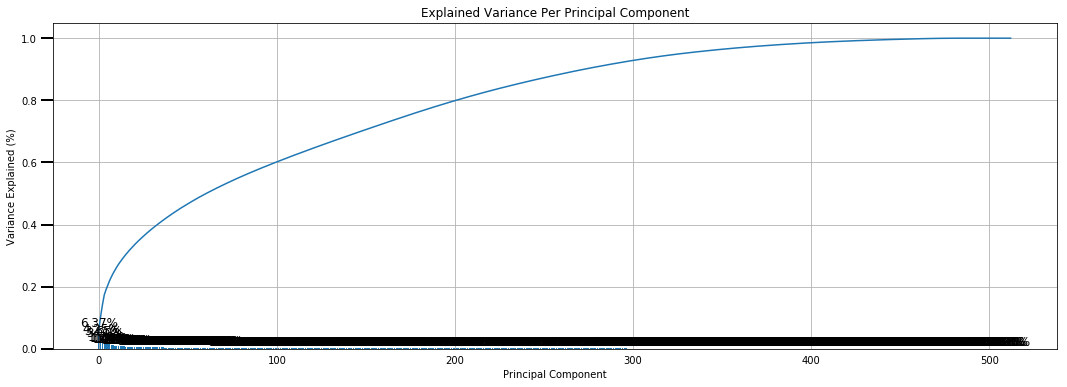

In [12]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
print(np.cumsum(pca.explained_variance_ratio_[:250])[-1])

pca250 = PCA(n_components=250)
X_pca250 = pca250.fit_transform(df_scale)

0.871454290944256


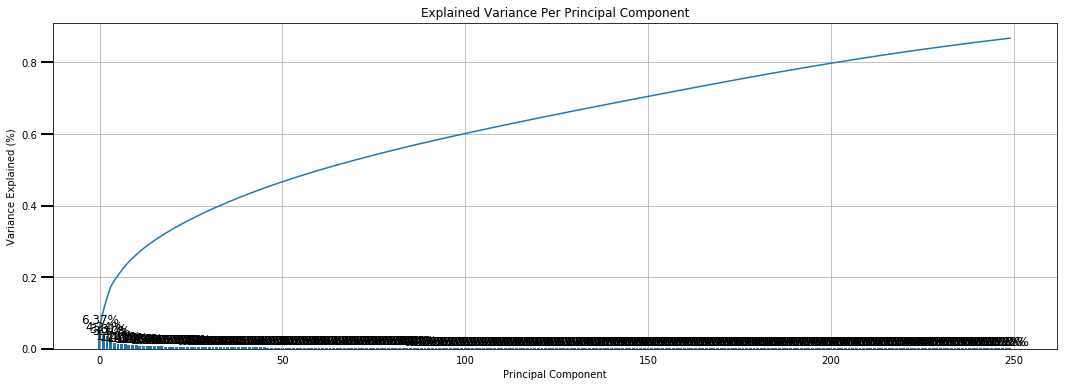

In [49]:
scree_plot(pca250)

#### Discussion 2.2: Perform Dimensionality Reduction

From the initial plot, the first 100 Principal components already explained more than 60% of the total variance, with the first highest variance being 6.37%. I will choose to keep 250 components as this explained 87% of the total variance. After this number, there seems to be a slow increase in the ratio of cumulative explained variance.

#### Step 2.3: Interpret Principal Components
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [14]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def map_PC_to_weight (pca, comp_no, df):
    
    PC_weight = {}
    for i, feature in enumerate(df.columns):
        PC_weight[feature] = pca.components_[comp_no][i]

    #print(PC_weight)
    names = ['feature', 'weight']
    formats = ['object', 'float64']
    dtype = dict(names=names, formats=formats)
    array = np.array(list(PC_weight.items()), dtype=dtype )
    
    #df_PC_weight = pd.DataFrame(PC_weight, index=[0]).T
    #print(df_PC_weight)
    
    #print(array)    
    df_PC_weight = pd.DataFrame(array)
    #print(df_PC_weight)
    df_PC_weight = df_PC_weight.sort_values(by='weight', ascending=False)
    #print(df_PC_weight)
    
    return df_PC_weight


df_PC_weight = map_PC_to_weight(pca250, 1, df_scale)

df_PC_weight

,feature,weight
336,Decade,0.154910
13,CJT_TYP_2,0.150472
92,FINANZ_SPARER,0.148322
291,ONLINE_AFFINITAET,0.148143
12,CJT_TYP_1,0.147683
97,GEBURTSJAHR,0.132214
39,D19_GESAMT_ANZ_24,0.126188
2,ALTERSKATEGORIE_FEIN,0.125162
89,FINANZ_ANLEGER,0.121808
38,D19_GESAMT_ANZ_12,0.119731


In [16]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_PC_weight = map_PC_to_weight(pca250, 2, df_scale)
df_PC_weight

,feature,weight
218,KBA13_HERST_BMW_BENZ,0.178842
267,KBA13_SEG_OBEREMITTELKLASSE,0.153657
253,KBA13_MERCEDES,0.153363
186,KBA13_BMW,0.149222
274,KBA13_SITZE_4,0.144144
270,KBA13_SEG_SPORTWAGEN,0.140098
122,KBA05_HERST1,0.128599
229,KBA13_KMH_211,0.124503
230,KBA13_KMH_250,0.121961
243,KBA13_KW_121,0.120702


In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_PC_weight = map_PC_to_weight(pca250, 3, df_scale)
df_PC_weight

,feature,weight
94,FINANZ_VORSORGER,0.112897
335,ALTERSKATEGORIE_GROB,0.110824
39,D19_GESAMT_ANZ_24,0.103138
16,CJT_TYP_5,0.100205
38,D19_GESAMT_ANZ_12,0.097610
69,D19_VERSAND_ANZ_24,0.096786
174,KBA13_ANTG3,0.095738
340,LP_LEBENSPHASE_FEIN_AgeGroup,0.095677
296,PLZ8_ANTG3,0.094643
175,KBA13_ANTG4,0.094466


In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_PC_weight = map_PC_to_weight(pca250, 4, df_scale)
df_PC_weight

,feature,weight
248,KBA13_KW_61_120,0.162353
278,KBA13_VORB_0,0.159309
228,KBA13_KMH_210,0.153614
275,KBA13_SITZE_5,0.137610
191,KBA13_CCM_1401_2500,0.129447
161,KBA05_VORB0,0.117422
216,KBA13_HERST_ASIEN,0.114245
239,KBA13_KRSZUL_NEU,0.111601
183,KBA13_BJ_2006,0.107389
140,KBA05_MAXBJ,0.106189


In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_PC_weight = map_PC_to_weight(pca250, 12, df_scale)
df_PC_weight

,feature,weight
115,KBA05_CCM1,0.115385
153,KBA05_SEG2,0.108839
243,KBA13_KW_121,0.108329
136,KBA05_KW1,0.108146
229,KBA13_KMH_211,0.107705
230,KBA13_KMH_250,0.106310
197,KBA13_CCM_2501,0.102274
164,KBA05_ZUL1,0.100805
132,KBA05_KRSKLEIN,0.099061
234,KBA13_KRSHERST_BMW_BENZ,0.096945


#### 2.3: Interpret Principal Components

The first principal component is mostly explained by Decade (which derived from 'PRAEGENDE_JUGENDJAHRE'), CJT_TYP_2, ONLINE_AFFINITAET, FINANZ_SPARER, CJT_TYP_1  as they have high positive weight. The bottom 3 negatively correlated features are
LP_LEBENSPHASE_FEIN_AgeGroup, CJT_TYP_5, FINANZ_VORSORGER. Few of the features are not available in Data Dictionary, we do not know what they are.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population


We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [17]:
# Over a number of different cluster counts...
def get_kmeans_score(data, cluster):

    # run k-means clustering on the data and...
    k_means = KMeans(n_clusters = cluster)
    model = k_means.fit(data)
    label = model.predict(data)
    
    # compute the average within-cluster distances.
    score = abs(model.score(data))
    
    return score
    

In [24]:
clusters = list(range(2, 31, 2))
print (clusters)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


In [25]:
%%time
# run k-means clustering 
scores = [MiniBatchKMeans(i).fit(X_pca250).score(X_pca250) for i in clusters]


CPU times: user 25 s, sys: 1.07 s, total: 26 s
Wall time: 26.4 s


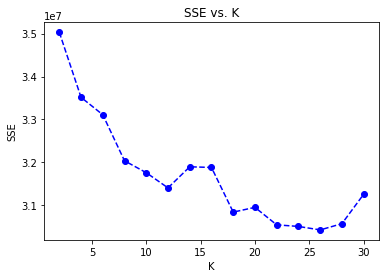

In [27]:
plt.plot(clusters, np.abs(scores), linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

From the scree plot, it seems that the rate of decrease is not substantial enough to suggest the need for an additional cluster after 12 where the average distance is starting to level out on the scree plot. Hence, I will choose 12 to refit the k-means model.

<br><br>


In [ ]:
%%time
# Investigate the change in within-cluster distance across number of clusters.
# Use matplotlib's plot function to visualize this relationship.

scores=[]
clusters = list(range(2, 31, 2))
#print (clusters)
#for cluster in range(1 ,11):
for cluster in clusters:
    score = get_kmeans_score(X_pca250, cluster)
    scores.append(score)
    
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

# DON'T SIMPLY RUN AS IT RUN QUITE LONG

In [29]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(12)
kmeans = kmeans.fit(X_pca250)
azdias_predict = kmeans.predict(X_pca250)

CPU times: user 58.6 s, sys: 99.5 ms, total: 58.7 s
Wall time: 59.1 s


### Step 3.2: Apply All Steps to the Customer Data
Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the clean_data() function we created earlier. (We assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a .fit() or .fit_transform() method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [39]:
%%time
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

CPU times: user 8.31 s, sys: 3.18 s, total: 11.5 s
Wall time: 11.7 s


In [35]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers, iscustomer=True)

customers.shape, customers.isnull().sum().sum()

Processing outlier columns
Cols to be removed:['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
ID Col to be removed: LNR
Processing OST_WEST_KZ
1.0    130382
0.0     11343
Name: OST_WEST_KZ, dtype: int64
Processing CAMEO_DEUG_2015
Processing CAMEO_DEU_2015
Processing PRAEGENDE_JUGENDJAHRE
Processing CAMEO_INTL_2015
Processing LP_LEBENSPHASE_FEIN
Processing WOHNLAGE
Processing KBA05_BAUMAX
Processing PLZ8_BAUMAX
Processing D19_LETZTER_KAUF_BRANCHE
Processing EINGEFUEGT_AM
Convert int cols to float
Processing Missing values in each rows
low_or_no_nanrow_df: (134207, 360)
high_nanrow_df: (57445, 360)
Impute Missing Values
Re-encode Multi-Level Categorical Features


((134207, 490), 0)

In [33]:
for col in df_scale.columns:
    if col not in customers.columns:
        print(col)

In [34]:
%%time

X_custscale = scaler.transform(customers)

X_custpca250 = pca250.transform(X_custscale)

X_cust_predict = kmeans.predict(X_custpca250)

X_cust_predict.shape

CPU times: user 2.31 s, sys: 743 ms, total: 3.05 s
Wall time: 3.11 s


### Step 3.3: Compare Customer Data to Demographics Data
At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's countplot() or barplot() function could be handy.
    - Recall the analysis we performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values. If we found that this group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making our computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help us make this inference. Alternatively, we can use the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [35]:
x = list(range(1, 13))
print(x)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


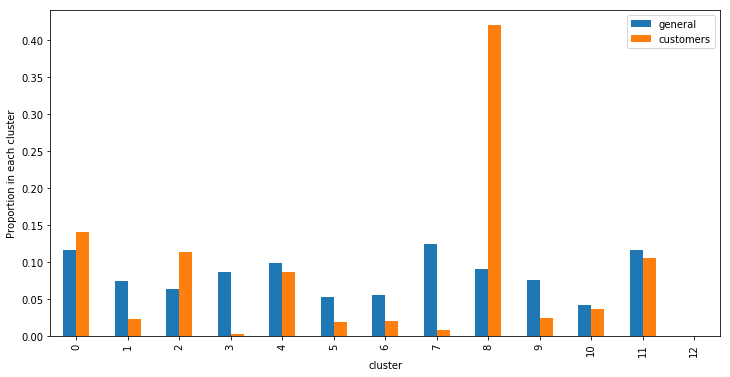

In [36]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general =  []
customer = []
clusters = list(range(0, 13))

for cluster in clusters:
    general.append((azdias_predict == cluster).sum() / len(azdias_predict))
    customer.append((X_cust_predict == cluster).sum() / len(X_cust_predict))

df_prop = pd.DataFrame({'cluster' : clusters, 'general' : general, 'customers':customer})

df_prop.plot(x='cluster', y = ['general', 'customers'], kind='bar', figsize=(12,6))
plt.ylabel('Proportion in each cluster')
plt.show()

In [37]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

def get_clusterctr_weights_PC(kmeans, PCcolkey, cluster_num):

    #print(kmeans.cluster_centers_)
    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 3), columns=PCcolkey)
    #print(weights.head())
    #print(weights.shape)
    centroid = weights.iloc[cluster_num, :]
    #print(centroid.shape)
    centroid_pos = centroid[centroid > 0].sort_values(ascending=False)
    centroid_neg = centroid[centroid < 0].sort_values(ascending=True)

    df_positve_negative = pd.DataFrame()
    df_positve_negative['Positive_PC_Num'] = centroid_pos[:10].index
    df_positve_negative['Positive_PC_Weight'] = centroid_pos[:10].reset_index(drop=True)

    df_positve_negative['Negative_PC_Num'] = centroid_neg[:10].index
    df_positve_negative['Negative_PC_Weight'] = centroid_neg[:10].reset_index(drop=True)

    
    return df_positve_negative


In [38]:
print(X_custpca250.shape)

df_cust_pca = pd.DataFrame(X_custpca250, columns=np.arange(1, 251))
print(df_cust_pca.shape)

(134229, 250)
(134229, 250)


In [39]:
df_pos_neg_PCweight = get_clusterctr_weights_PC(kmeans, df_cust_pca.keys(), 8)
df_pos_neg_PCweight

,Positive_PC_Num,Positive_PC_Weight,Negative_PC_Num,Negative_PC_Weight
0,1,6.298,2,-1.937
1,4,3.405,12,-1.151
2,3,1.314,11,-0.750
3,7,0.739,16,-0.439
4,24,0.545,26,-0.387
5,30,0.434,13,-0.287
6,25,0.433,49,-0.234
7,8,0.405,22,-0.183
8,6,0.374,18,-0.179
9,10,0.258,17,-0.165


In [40]:
df_pos_neg_PCweight = get_clusterctr_weights_PC(kmeans, df_cust_pca.keys(), 2)
df_pos_neg_PCweight

,Positive_PC_Num,Positive_PC_Weight,Negative_PC_Num,Negative_PC_Weight
0,3,7.993,2,-2.948
1,5,1.770,10,-0.580
2,13,1.194,37,-0.512
3,1,1.149,25,-0.376
4,11,0.909,20,-0.364
5,9,0.856,40,-0.324
6,7,0.576,35,-0.303
7,27,0.407,23,-0.250
8,8,0.331,33,-0.249
9,6,0.316,16,-0.221


In [41]:
df_pos_neg_PCweight = get_clusterctr_weights_PC(kmeans, df_cust_pca.keys(), 0)
df_pos_neg_PCweight

,Positive_PC_Num,Positive_PC_Weight,Negative_PC_Num,Negative_PC_Weight
0,1,3.240,2,-5.560
1,12,0.555,4,-2.159
2,10,0.398,3,-1.298
3,48,0.263,5,-1.145
4,41,0.212,7,-0.614
5,35,0.180,13,-0.196
6,76,0.149,49,-0.148
7,36,0.140,45,-0.140
8,58,0.139,51,-0.132
9,16,0.132,63,-0.125


#### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster that is overrepresented in the customer data compared to the general population are `cluster 8`, 2 and 0. 

For `cluster 8`, the dominating principal components (PC) which have the high positive weights are {PC 1 and PC 4} with weight of 6.298 and 3.405 respectively. The negative PC in `cluster 8` is {PC 2} with -1.937 weight and {PC 12} with -1.151 weight.
- Positive
    - Refer back to step2.3, the corresponding features with high weights for 1st principal component {PC 1} are Decade (the engineered feature which derived from 'PRAEGENDE_JUGENDJAHRE') 0.154910, CJT_TYP_2 (no info) 0.150472, FINANZ_SPARER (financial typology: money saver) 0.148322, ONLINE_AFFINITAET (online affinity) 0.148143, CJT_TYP_1 (no info) 0.147683, GEBURTSJAHR (year of birth) 0.132214. 
    - And for {PC 4}, the corresponding features with high weights are KBA13_KW_61_120 (share of cars with an engine power between 61 and 120 KW - PLZ8) 0.162353, KBA13_VORB_0 (share of cars with no preowner - PLZ8) 0.159309, KBA13_KMH_210 (share of cars with a greater max speed than 210 km/h within the PLZ8) 0.153614, KBA13_SITZE_5 (number of cars with 5 seats in the PLZ8) 0.137610.
- Negative
    - The corresponding high weight features for PC 2 are KBA13_HERST_BMW_BENZ (share of BMW & Mercedes Benz within the PLZ8) 0.178842, KBA13_SEG_OBEREMITTELKLASSE share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.) 0.153657, KBA13_MERCEDES (share of MERCEDES within the PLZ8) 0.153363.
    - The corresponding high weight features for PC 12 are KBA05_CCM1 (share of cars with less than 1399ccm) 0.115385, KBA05_SEG2 (share of small and very small cars) 0.108839.

It seems that people with higher age, money saver type, with tendencies of online, with above average financial condition (inference from the car types) are the potential customers. But this is contrast with people that are super rich (inference from the luxury car types) and poor (inference from the small cars) are not the target audience of the company.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_train.shape

(42962, 367)

In [3]:
%%time

def split_code_For_wealth(x):
    if not pd.isna(x):
        return int(str(x)[0])
    return np.nan

def split_code_For_lifestage(x):
    if not pd.isna(x):
        return int(str(x)[1])
    return np.nan


def clean_data(df, iscustomer=False, OutlierRowsRemoval=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = df.copy()
    
    if iscustomer:
        df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
    
    
    
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    
    # Read the feat_info.csv back into feat_info   
    feat_info= pd.read_csv('feat_info.csv', sep=',' , converters={'missing_or_unknown': literal_eval})

    feat_info.drop(feat_info[feat_info['attribute']=='BIP_FLAG'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='CAMEO_DEUINTL_2015'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='D19_KK_KUNDENTYP'].index, inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='GEOSCORE_KLS7'].index, inplace=True)
    feat_info.replace(['HAUSHALTSSTRUKTUR'],'STRUKTURTYP', inplace=True)
    feat_info.replace(['KBA13_CCM_1400_2500'],'KBA13_CCM_1401_2500', inplace=True)
    feat_info.replace(['SOHO_FLAG'],'SOHO_KZ', inplace=True)
    feat_info.drop(feat_info[feat_info['attribute']=='WACHSTUMSGEBIET_NB'].index, inplace=True)

    # Identify missing or unknown data values and convert them to NaNs.
    for attribute, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        df.loc[df[attribute].isin(missing), attribute] = np.NaN


    # Remove the outlier columns from the dataset. 
    # More than 80% of missing values in these column. I treated these columns as outlier 
    # for removal since so high percentage of data was missing.
    print('Processing outlier columns')
    cols_to_remove = []
    for col in df.columns:
        if (df[col].isnull().mean() > 0.8) :
            cols_to_remove.append(col)
    print('Cols to be removed:' + str(cols_to_remove))

    # Remove ID Columns 
    for column in df.columns:
        if df[column].nunique() == len(df):
            print('ID Col to be removed:', column)

    cols_to_remove.append('LNR')


    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing OST_WEST_KZ')
    #df.loc[:, 'OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
    df['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
    print(df['OST_WEST_KZ'].value_counts())

    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    # Looks like there are some number being stored as str. Convert them all to float
    print('Processing CAMEO_DEUG_2015')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')

    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing CAMEO_DEU_2015')
    labels = df['CAMEO_DEU_2015'].dropna().unique().tolist()
    labels.sort()
    cameo_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].map(cameo_mapping)  

    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    print('Processing PRAEGENDE_JUGENDJAHRE')
    '''
    Code for Decade:
    1: 40s
    2: 50s
    3: 60s
    4: 70s
    5: 80s
    6: 90s

    Code for Movement:
    1: Mainstream
    2: Avantgarde
    '''

    decade_mapping = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_mapping = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
    cols_to_remove.append('PRAEGENDE_JUGENDJAHRE')


    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    print('Processing CAMEO_INTL_2015')
    '''
    Code for Household Wealth:
    1: Wealthy Households
    2: Prosperous Households
    3: Comfortable Households
    4: Less Affluent Households
    5: Poorer Households

    Code for Life Stage of a person:
    1: Pre-Family Couples & Singles
    2: Young Couples With Children
    3: Families With School Age Children
    4: Older Families &  Mature Couples
    5: Elders In Retirement
    '''

    df['Wealth'] = df['CAMEO_INTL_2015'].apply(split_code_For_wealth)
    df['Life_Stage'] = df['CAMEO_INTL_2015'].apply(split_code_For_lifestage)
    cols_to_remove.append('CAMEO_INTL_2015')



    # Investigate "LP_LEBENSPHASE_FEIN" and engineer new variables.
    # Investigate ("LP_LEBENSPHASE_FEIN" || "LP_LEBENSPHASE_GROB"), ("LP_FAMILIE_GROB" || "LP_FAMILIE_FEIN"), 
    # ("LP_STATUS_GROB" || "LP_STATUS_FEIN")
    # It seems that these few features have to look side-by-side
    print('Processing LP_LEBENSPHASE_FEIN')
    '''
    After looking at their values, I decided 

    1) to drop "LP_FAMILIE_FEIN" and keep "LP_FAMILIE_GROB" - as "_FEIN" is too fine/detail of an information/category
    2) to drop "LP_STATUS_FEIN" and keep "LP_STATUS_GROB".
    3) to drop "LP_LEBENSPHASE_GROB" and "LP_LEBENSPHASE_FEIN", but re-engineer "LP_LEBENSPHASE_FEIN" to extract the Age Group
        which are not available thru "LP_FAMILIE_GROB" & "LP_STATUS_GROB". 
        This is because "LP_LEBENSPHASE_FEIN" has 3 parts of information - FamilyStatus, Income, AgeGroup. The first 2 parts
        are categorized and available thru "LP_FAMILIE_GROB" and "LP_STATUS_GROB" respectively. 
    '''

    '''
    Code for FamilyStatus:
    1: Single
    2: Couple
    3: SingleParent
    4: Family
    5: MultipersonHousehold

    Code for Income :
    1: LowIncomeEarners
    2: AverageEarners
    3: Independants
    4: HouseOwners
    5: TopEarners

    Code for Age Group:
    1: YoungerAge
    2: MiddleAge
    3: Higher/AdvancedAge 
    4: RetirementAge

    '''

    #It seems that LP_FAMILIE_GROB and LP_STATUS_GROB are already in the range of 1 - 5. There are no mapping needed. 
    AgeGroup_mapping = {1:1, 2:2, 3:1, 4:2, 5:3, 6:4, 7:3, 8:4, 9:2, 10:2, 11:3, 12:4, 13:3, 14:1, 15:3,
                        16:3, 17:2, 18:1, 19:3, 20:3, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1,
                        31:3, 32:3, 33:1, 34:3, 35:1, 36:3, 37:3, 38:4, 39:2, 40:4}

    df['LP_LEBENSPHASE_FEIN_AgeGroup'] = df['LP_LEBENSPHASE_FEIN'].map(AgeGroup_mapping)
    cols_to_remove.extend(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'])
    #cols_to_remove.extend(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'])
    #cols_to_remove.extend(['LP_LEBENSPHASE_GROB'])
    #cols_to_remove.extend(['LP_LEBENSPHASE_FEIN'])
    #cols_to_remove.extend(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_FEIN'])


    # Investigate "WOHNLAGE" and fix
    print('Processing WOHNLAGE')
    df['WOHNLAGE'] = df['WOHNLAGE'].replace({0: np.NaN})

    # Investigate "KBA05_BAUMAX" and fix
    print('Processing KBA05_BAUMAX')
    df['KBA05_BAUMAX'] = df['KBA05_BAUMAX'].replace({0: np.NaN})

    # Investigate "PLZ8_BAUMAX" and fix
    print('Processing PLZ8_BAUMAX')
    df['PLZ8_BAUMAX'] = df['PLZ8_BAUMAX'].replace({0: np.NaN})


    # Re-encode categorical variable(s) but with object type to be kept in the analysis.
    print('Processing D19_LETZTER_KAUF_BRANCHE')
    labels = df['D19_LETZTER_KAUF_BRANCHE'].dropna().unique().tolist()
    labels.sort()
    BRANCHE_mapping = {key: value for key, value in zip(labels, list(range(1, len(labels)+1)))}
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].map(BRANCHE_mapping)

    # Column EINGEFUEGT_AM can be converted to datetime
    print('Processing EINGEFUEGT_AM')
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].dt.year
    


    '''
    Reference to https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection#Remove-Collinear-Variables

    # Threshold for removing correlated variables
    threshold = 0.9

    # Absolute value correlation matrix
    corr_matrix = df.corr().abs()
    corr_matrix.head()
    #sns.heatmap(corr)

    # Upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    upper.head()

    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print('There are %d columns to remove.' % (len(to_drop)))
    print(to_drop)    

    cols_to_remove.extend(['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_DEUG_2015', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12',
    'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
    'GEBURTSJAHR', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG3',
    'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_ZG11', 'Decade', 'Movement', 'Wealth'])
    
    #cols_to_remove.extend(['ANZ_STATISTISCHE_HAUSHALTE', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 
    #                       'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 
    #                       'D19_VERSAND_ONLINE_QUOTE_12', 'GEBURTSJAHR', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 
    #                       'KBA13_KMH_250', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 
    #                       'VK_ZG11'])
    
    '''    
    
    
    
    df = df.drop(cols_to_remove, axis=1)

    
    if OutlierRowsRemoval:
        # Write code to divide the data into two subsets based on the number of missing
        # values in each row.
        print('Processing Missing values in each rows')

        threshold = 25
        if iscustomer:
            threshold = 35

        df['nan_row'] = df.isnull().sum(axis=1) # count the null for each row

        low_or_no_nanrow_df = df.loc[df['nan_row'] <= threshold, :] 
        high_nanrow_df = df.loc[df['nan_row'] > threshold, :]

        low_or_no_nanrow_df = low_or_no_nanrow_df.drop('nan_row', axis=1)
        high_nanrow_df = high_nanrow_df.drop('nan_row', axis=1)

        print('low_or_no_nanrow_df: ' + str(low_or_no_nanrow_df.shape))
        print('high_nanrow_df: ' + str(high_nanrow_df.shape))

        df = df.drop('nan_row', axis=1)
        df = low_or_no_nanrow_df
    
    
    #Impute Missing Values NaN
    print('Impute Missing Values')
    with active_session():
        # using Sklearn SimpleImputer 
        imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
        df_impute = pd.DataFrame(imputer.fit_transform(df))
        df_impute.columns = df.columns
        df_impute.index = df.index   
        
        #Run too long. Don't want
        #imputer = KNNImputer(n_neighbors=3, weights="uniform")
        #df_impute = pd.DataFrame(imputer.fit_transform(df))
        #df_impute.columns = df.columns
        #df_impute.index = df.index   
        #df_impute = df_impute.astype(int)
        
        
    #Re-encode Multi-Level Categorical Features
    print('Re-encode Multi-Level Categorical Features')
    category_features = ['STRUKTURTYP', 'NATIONALITAET_KZ', 'AGER_TYP', 'SHOPPER_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
    'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'CAMEO_DEUG_2015',
     'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'WOHNLAGE', 'KBA05_MAXHERST','LP_LEBENSPHASE_FEIN_AgeGroup'
    ]
    

    df = pd.get_dummies(df_impute, columns=category_features)
    
    # Convert ints to floats - have issue with CatBoost cat_features
    print('Convert int cols to float')
    for col in df.columns:
        if df[col].dtype == np.uint8:
            df[col] = df[col].astype(np.float64)
    
    
    # Return the cleaned dataframe.
    return df


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.5 µs


In [4]:
%%time
mailout_train_clean = clean_data(mailout_train, iscustomer=False, OutlierRowsRemoval=False)
mailout_train_clean.shape

Processing outlier columns
Cols to be removed:['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
ID Col to be removed: LNR
Processing OST_WEST_KZ
1.0    26752
0.0     8433
Name: OST_WEST_KZ, dtype: int64
Processing CAMEO_DEUG_2015
Processing CAMEO_DEU_2015
Processing PRAEGENDE_JUGENDJAHRE
Processing CAMEO_INTL_2015
Processing LP_LEBENSPHASE_FEIN
Processing WOHNLAGE
Processing KBA05_BAUMAX
Processing PLZ8_BAUMAX
Processing D19_LETZTER_KAUF_BRANCHE
Processing EINGEFUEGT_AM
Impute Missing Values
Re-encode Multi-Level Categorical Features
Convert int cols to float
CPU times: user 4.45 s, sys: 3.44 s, total: 7.88 s
Wall time: 7.95 s


In [5]:
mailout_train_clean.isnull().sum().sum()

0

In [6]:
mailout_train_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE_8.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,LP_LEBENSPHASE_FEIN_AgeGroup_1.0,LP_LEBENSPHASE_FEIN_AgeGroup_2.0,LP_LEBENSPHASE_FEIN_AgeGroup_3.0,LP_LEBENSPHASE_FEIN_AgeGroup_4.0
0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,9.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
X = mailout_train_clean.drop('RESPONSE', axis=1)
y = mailout_train_clean['RESPONSE']
X.shape, y.shape

((42962, 473), (42962,))

print('Types of Columns:')
all_cols = X.columns.tolist()

pd.set_option('display.max_rows', 500)

print(X[all_cols].dtypes)

### <p style="color:blue"> First Try with train_test_split simply uses any classifier with simply plugged hyperparameters to have a feel  </p>

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34369 samples.
Testing set has 8593 samples.


In [237]:
#With LP_LEBENSPHASE_FEIN_AgeGroup
#Remove 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'
#Re-encode 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', LP_LEBENSPHASE_FEIN_AgeGroup
#include CAMEO_DEU_2015

learner = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 30)

learner.fit(X_train, y_train)
predictions_test = learner.predict(X_test)
results = roc_auc_score(y_test, predictions_test)
print("ROC score on validation data: {:.4f}".format(results))

ROC score on validation data: 0.7626


    Imbalance dataset. Too many zero as compared to one. Use ROC AUC for evaluation metrics


###  <p style="color:blue">Try with some different base models with `train_test_split` the data to see which classifier to pick forward </p>

In [7]:
#Taken from Udacity supplementary visualization code visuals.py

#import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 2, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    data = []
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['roc_train', 'roc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
                ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
                ax[j//2, j%2].set_xlabel("Sample Size in Training")
                ax[j//2, j%2].set_xlim((-0.1, 3.0))
                data.append([learner, i, metric, results[learner][i][metric]])

    df_results = pd.DataFrame(data, columns=['learner', 'samplesize', 'metric', 'score'])
    df_results['samplesize'] = df_results['samplesize'].map({0:'1%', 1:'10%', 2:'100%'})
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("ROC Score")
    ax[0, 1].set_ylabel("ROC Score")
    
    # Add titles
    ax[0, 0].set_title("ROC Score on Training Subset")
    ax[0, 1].set_title("ROC Score on Testing set")
    
    # Add horizontal lines for naive predictors
    #ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    #ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    #ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    #ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 0].set_ylim((0, 1))
    ax[0, 1].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()
    print(df_results.loc[(df_results['samplesize']=='100%')& (df_results['metric']=='roc_test')].groupby(['learner', 'metric'])['score'].mean())
    display(df_results)

In [10]:
# Import train_test_split
#from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34369 samples.
Testing set has 8593 samples.


In [11]:
#from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    
    outputs:
        results: score
    '''    
   
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    #results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    #results['pred_time'] = end - start

    results['roc_train'] = roc_auc_score(y_train, predictions_train)
    results['roc_test'] = roc_auc_score(y_test, predictions_test)
        
    
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [20]:
%%time
np.random.seed(42)

clf_A = xgb.XGBRegressor(random_state=42) 
clf_B = lgb.LGBMRegressor(random_state=42)
clf_C = cb.CatBoostRegressor(random_state=42)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(np.abs(0.1 * samples_100))
samples_1 = int(np.abs(0.01 * samples_100))


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)



XGBRegressor trained on 343 samples.
XGBRegressor trained on 3436 samples.
XGBRegressor trained on 34369 samples.
LGBMRegressor trained on 343 samples.
LGBMRegressor trained on 3436 samples.
LGBMRegressor trained on 34369 samples.
Learning rate set to 0.032261
0:	learn: 0.1409269	total: 22.6ms	remaining: 22.6s
1:	learn: 0.1403676	total: 39.1ms	remaining: 19.5s
2:	learn: 0.1399128	total: 55.4ms	remaining: 18.4s
3:	learn: 0.1388946	total: 73.7ms	remaining: 18.4s
4:	learn: 0.1382427	total: 90ms	remaining: 17.9s
5:	learn: 0.1378188	total: 106ms	remaining: 17.5s
6:	learn: 0.1371927	total: 122ms	remaining: 17.3s
7:	learn: 0.1361742	total: 139ms	remaining: 17.2s
8:	learn: 0.1350828	total: 155ms	remaining: 17.1s
9:	learn: 0.1342885	total: 176ms	remaining: 17.4s
10:	learn: 0.1335889	total: 192ms	remaining: 17.3s
11:	learn: 0.1332535	total: 209ms	remaining: 17.2s
12:	learn: 0.1328440	total: 226ms	remaining: 17.1s
13:	learn: 0.1324298	total: 242ms	remaining: 17.1s
14:	learn: 0.1320035	total: 259m

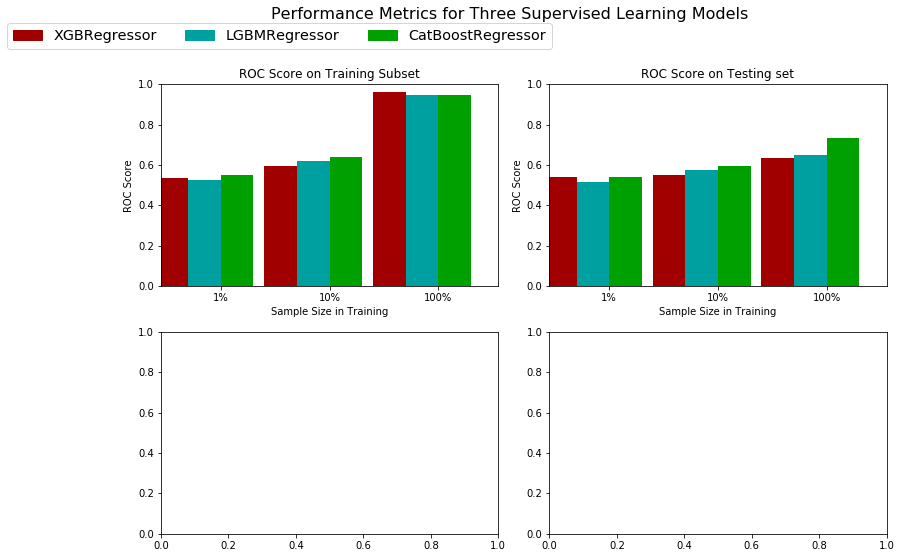

learner            metric  
CatBoostRegressor  roc_test    0.735948
LGBMRegressor      roc_test    0.652411
XGBRegressor       roc_test    0.637418
Name: score, dtype: float64


,learner,samplesize,metric,score
0,XGBRegressor,1%,roc_train,0.536793
1,XGBRegressor,10%,roc_train,0.593391
2,XGBRegressor,100%,roc_train,0.962423
3,XGBRegressor,1%,roc_test,0.542010
4,XGBRegressor,10%,roc_test,0.549749
5,XGBRegressor,100%,roc_test,0.637418
6,LGBMRegressor,1%,roc_train,0.528493
7,LGBMRegressor,10%,roc_train,0.622107
8,LGBMRegressor,100%,roc_train,0.946304
9,LGBMRegressor,1%,roc_test,0.515530


In [29]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [30]:
%%time
np.random.seed(42)

clf_A = xgb.XGBClassifier(random_state=42) 
clf_B = lgb.LGBMClassifier(random_state=42, silent=True, verbose=-1)
clf_C = cb.CatBoostClassifier(random_state=42)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(np.abs(0.1 * samples_100))
samples_1 = int(np.abs(0.01 * samples_100))


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)



XGBClassifier trained on 343 samples.
XGBClassifier trained on 3436 samples.
XGBClassifier trained on 34369 samples.
LGBMClassifier trained on 343 samples.
LGBMClassifier trained on 3436 samples.
LGBMClassifier trained on 34369 samples.
Learning rate set to 0.006524
0:	learn: 0.6824921	total: 9.44ms	remaining: 9.43s
1:	learn: 0.6712121	total: 18ms	remaining: 8.97s
2:	learn: 0.6611017	total: 26.8ms	remaining: 8.91s
3:	learn: 0.6505286	total: 35.6ms	remaining: 8.87s
4:	learn: 0.6403570	total: 44.5ms	remaining: 8.86s
5:	learn: 0.6298463	total: 53.3ms	remaining: 8.84s
6:	learn: 0.6197349	total: 62.1ms	remaining: 8.81s
7:	learn: 0.6096137	total: 70.5ms	remaining: 8.74s
8:	learn: 0.5995984	total: 79.4ms	remaining: 8.75s
9:	learn: 0.5904316	total: 88.2ms	remaining: 8.74s
10:	learn: 0.5810583	total: 96.9ms	remaining: 8.71s
11:	learn: 0.5723742	total: 106ms	remaining: 8.69s
12:	learn: 0.5626317	total: 114ms	remaining: 8.65s
13:	learn: 0.5540242	total: 123ms	remaining: 8.63s
14:	learn: 0.5455317

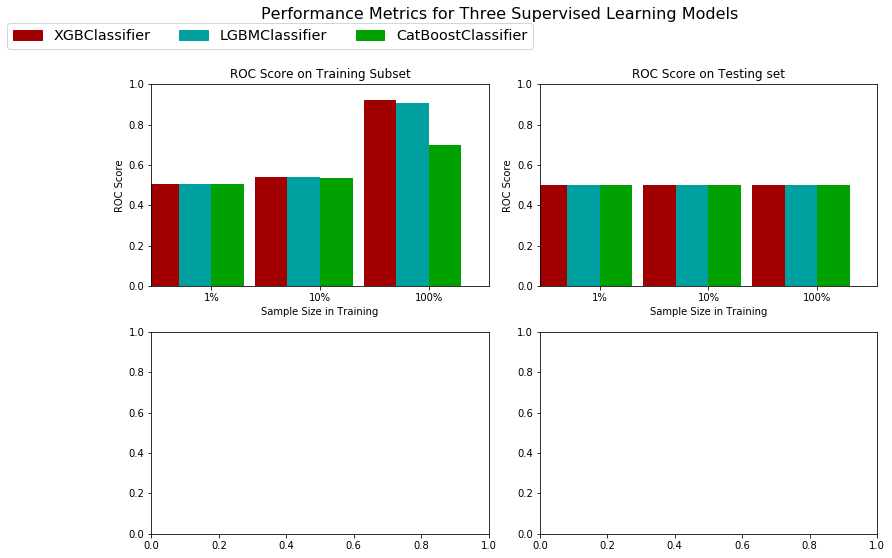

learner             metric  
CatBoostClassifier  roc_test    0.500000
LGBMClassifier      roc_test    0.499941
XGBClassifier       roc_test    0.500000
Name: score, dtype: float64


,learner,samplesize,metric,score
0,XGBClassifier,1%,roc_train,0.505854
1,XGBClassifier,10%,roc_train,0.538732
2,XGBClassifier,100%,roc_train,0.923709
3,XGBClassifier,1%,roc_test,0.499941
4,XGBClassifier,10%,roc_test,0.500000
5,XGBClassifier,100%,roc_test,0.500000
6,LGBMClassifier,1%,roc_train,0.505854
7,LGBMClassifier,10%,roc_train,0.538732
8,LGBMClassifier,100%,roc_train,0.907277
9,LGBMClassifier,1%,roc_test,0.500000


In [31]:
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)


In [12]:
#Taken from Udacity supplementary visualization code visuals.py
# OPTIONAL
# TAKING TOO LONG TIME
#from sklearn.model_selection import learning_curve

def draw_learning_curves(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
       
    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")
    
    #plt.xticks(np.arange(0., 100.5, 10))
    
    plt.legend(loc="best")

    plt.show()

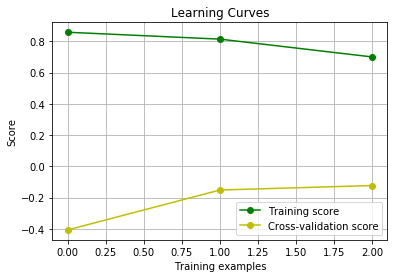

CPU times: user 10min 25s, sys: 3.95 s, total: 10min 29s
Wall time: 10min 35s


In [13]:
%%time
clf_A = xgb.XGBRegressor(random_state=42)

draw_learning_curves(X, y, estimator=clf_A, num_trainings=3)

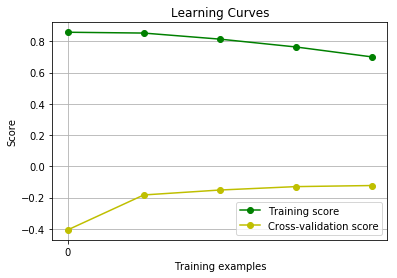

In [21]:
clf_A = xgb.XGBRegressor(random_state=42)

draw_learning_curves(X, y, estimator=clf_A, num_trainings=5)

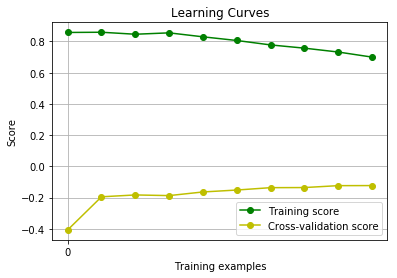

CPU times: user 35min, sys: 9.15 s, total: 35min 9s
Wall time: 35min 37s


In [24]:
%%time
clf_A = xgb.XGBRegressor(random_state=42)

draw_learning_curves(X, y, estimator=clf_A, num_trainings=10)

    Since the data is imbalance, too little response of 1, will used cross validation to maximize the training

###  <p style="color:blue"> Try with few base models but now with `stratified k-fold cross-validation` to see which classifier to pick forward

In [8]:
# Use stratified K-folds of 5 
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X, y)


5

In [9]:
# machine learning pipeline
def create_pipeline(clf, scaler='standard'):
    
    if scaler == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    pipeline = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [12]:
def cross_validate(model, X, y, kf): 
    '''
    inputs:
       - model: the learning algorithm 
       - X: training set
       - y: label
       - kf: stratified k-fold
    
    return:
        - results: score 
    '''    
   
    results = {}
    
    start = time() # Get start time
    cv_score = cross_val_score(model, X, y, cv=kf, n_jobs=1, scoring='roc_auc')
    end = time() # Get end time

    results['roc'] = cv_score
    
    
    # Success
    #print("{} score: {} .".format(model.steps[1][1].__class__.__name__), cv_score.mean())
    #print(model)
    
    # Return the results
    return results

In [13]:
def output_score(results):
    data = []

    # Format the score results
    for k, model in enumerate(results.keys()):
        for j, metric in enumerate(['roc']):
            for i in np.arange(5):
                data.append([model, i, metric, results[model][metric][i]])

    df_results = pd.DataFrame(data, columns=['model', 'k-fold', 'metric', 'score'])
    print(df_results.groupby(['model'])['score'].mean())
    display(df_results)

In [42]:
#Taken from Udacity supplementary visualization code visuals.py
# OPTIONAL
# TAKING TOO LONG TIME
def draw_learning_curves(X, y, estimator, kf ,num_trainings=3):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=kf, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
       
    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")
    
    
    plt.legend(loc="best")

    plt.show()

In [51]:
%%time

'''
# Main block to loop thru few base models

'''

scaler = 'standard'  # or minmaxscaler

clf_A = xgb.XGBRegressor(random_state=42) 
clf_B = lgb.LGBMRegressor(random_state=42, silent=True, verbose=-1)
clf_C = cb.CatBoostRegressor(random_state=42)


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    
    pipeline = create_pipeline(clf, scaler)
    results[clf_name] = cross_validate(pipeline, X, y, kf)
    print(pipeline.steps[1][1].__class__.__name__)
    #draw_learning_curves(X, y, pipeline, kf, 5)
    
output_score(results)

XGBRegressor
LGBMRegressor
Learning rate set to 0.073255
0:	learn: 0.1103997	total: 119ms	remaining: 1m 58s
1:	learn: 0.1102867	total: 255ms	remaining: 2m 7s
2:	learn: 0.1101898	total: 371ms	remaining: 2m 3s
3:	learn: 0.1100992	total: 483ms	remaining: 2m
4:	learn: 0.1100351	total: 586ms	remaining: 1m 56s
5:	learn: 0.1099281	total: 681ms	remaining: 1m 52s
6:	learn: 0.1098587	total: 792ms	remaining: 1m 52s
7:	learn: 0.1097981	total: 901ms	remaining: 1m 51s
8:	learn: 0.1097867	total: 987ms	remaining: 1m 48s
9:	learn: 0.1097491	total: 1.11s	remaining: 1m 49s
10:	learn: 0.1096766	total: 1.21s	remaining: 1m 48s
11:	learn: 0.1096603	total: 1.29s	remaining: 1m 46s
12:	learn: 0.1096024	total: 1.42s	remaining: 1m 48s
13:	learn: 0.1095907	total: 1.5s	remaining: 1m 45s
14:	learn: 0.1095316	total: 1.61s	remaining: 1m 45s
15:	learn: 0.1095222	total: 1.71s	remaining: 1m 45s
16:	learn: 0.1095089	total: 1.79s	remaining: 1m 43s
17:	learn: 0.1094954	total: 1.86s	remaining: 1m 41s
18:	learn: 0.1094447	tot

,model,k-fold,metric,score
0,XGBRegressor,0,roc,0.581738
1,XGBRegressor,1,roc,0.606753
2,XGBRegressor,2,roc,0.632824
3,XGBRegressor,3,roc,0.636175
4,XGBRegressor,4,roc,0.583152
5,LGBMRegressor,0,roc,0.668723
6,LGBMRegressor,1,roc,0.666769
7,LGBMRegressor,2,roc,0.679848
8,LGBMRegressor,3,roc,0.677199
9,LGBMRegressor,4,roc,0.670486


CPU times: user 14min 4s, sys: 14.1 s, total: 14min 18s
Wall time: 14min 34s


In [52]:
%%time
np.random.seed(42)

'''
# Main block to loop thru few base models

'''

scaler = 'standard'  # or minmaxscaler

clf_A = xgb.XGBClassifier(random_state=42) 
clf_B = lgb.LGBMClassifier(random_state=42, silent=True, verbose=-1)
clf_C = cb.CatBoostClassifier(random_state=42)


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    
    pipeline = create_pipeline(clf, scaler)
    results[clf_name] = cross_validate(pipeline, X, y, kf)
    print(pipeline.steps[1][1].__class__.__name__)
    #draw_learning_curves(X, y, pipeline, kf, 5)
    
output_score(results)

XGBClassifier
LGBMClassifier
Learning rate set to 0.046653
0:	learn: 0.5983159	total: 108ms	remaining: 1m 47s
1:	learn: 0.5175781	total: 213ms	remaining: 1m 46s
2:	learn: 0.4494029	total: 308ms	remaining: 1m 42s
3:	learn: 0.3916853	total: 428ms	remaining: 1m 46s
4:	learn: 0.3430127	total: 528ms	remaining: 1m 45s
5:	learn: 0.3019401	total: 651ms	remaining: 1m 47s
6:	learn: 0.2673331	total: 773ms	remaining: 1m 49s
7:	learn: 0.2358738	total: 896ms	remaining: 1m 51s
8:	learn: 0.2115150	total: 1.01s	remaining: 1m 51s
9:	learn: 0.1910204	total: 1.13s	remaining: 1m 51s
10:	learn: 0.1737291	total: 1.22s	remaining: 1m 49s
11:	learn: 0.1588675	total: 1.33s	remaining: 1m 49s
12:	learn: 0.1462584	total: 1.44s	remaining: 1m 49s
13:	learn: 0.1356527	total: 1.54s	remaining: 1m 48s
14:	learn: 0.1264723	total: 1.65s	remaining: 1m 48s
15:	learn: 0.1185990	total: 1.76s	remaining: 1m 48s
16:	learn: 0.1117713	total: 1.88s	remaining: 1m 48s
17:	learn: 0.1059977	total: 1.97s	remaining: 1m 47s
18:	learn: 0.10

,model,k-fold,metric,score
0,XGBClassifier,0,roc,0.650216
1,XGBClassifier,1,roc,0.696204
2,XGBClassifier,2,roc,0.690809
3,XGBClassifier,3,roc,0.674581
4,XGBClassifier,4,roc,0.667005
5,LGBMClassifier,0,roc,0.705293
6,LGBMClassifier,1,roc,0.721089
7,LGBMClassifier,2,roc,0.725283
8,LGBMClassifier,3,roc,0.701038
9,LGBMClassifier,4,roc,0.688492


CPU times: user 15min 21s, sys: 20 s, total: 15min 41s
Wall time: 15min 56s


#### Looks like we are going to pick CatBoostClassifier based on the score of the base model

###  <p style="color:blue"> Optimized and Tuned the Model with BayesSearchCV </p>



In [13]:
#Referenced https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes/data

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

clf = cb.CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', verbose =False)

search_spaces = {
    'iterations': Integer(10, 300),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'random_strength': Real(0.00000001, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'border_count': Integer(1, 255),
    'l2_leaf_reg': Integer(2, 30),
    'scale_pos_weight':Real(0.01, 1.0, 'uniform')
}

optimizer = BayesSearchCV(
            clf,
            search_spaces,
            scoring = 'roc_auc',
            cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42),
            n_iter = 100,
            n_jobs = 1,
            return_train_score=False,
            refit=True,
            optimizer_kwargs={'base_estimator': 'GP'},
            random_state=42
)



In [184]:
counter = 0

def onstep(res):
    global counter
    args = res.x
    x0 = res.x_iters
    y0 = res.func_vals
    print('Last eval: ', x0[-1], ' - Score ', y0[-1])
    print('Current iter: ', counter, ' - Score ', res.fun, ' - Args: ', args)
    counter = counter+1


def report_perf(optim_result):

    # Get optimizer cv_results  
    model_results = pd.DataFrame(optimizer.cv_results_)    
    # Print best parameters    
    best_params = pd.Series(optimizer.best_params_)
    print('Model #{} \n Best ROC-AUC: {} \n Best params: {} \n'.format(len(model_results),
        np.round(optimizer.best_score_, 4), optimizer.best_params_))      

In [63]:
%%time
#class_weights = (1, sum(y == 0) / sum(y == 1))
#categorical_features_indices = np.where(X.dtypes != np.float)[0]

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

clf = cb.CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', silent=True)
search_spaces = {
            'iterations': Integer(10, 300),
            'depth':Integer(2,8),
            'learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'l2_leaf_reg':Integer(1, 500),
            'bagging_temperature':Real(0.000000001, 1000, 'log-uniform'),
            'border_count':Integer(1,255),
            'rsm':Real(0.01, 1.0, 'uniform'),
            'random_strength':Real(0.000000001, 10, 'log-uniform'),
            'scale_pos_weight':Real(0.01, 1.0, 'uniform')
            }

optimizer = BayesSearchCV(
                    clf,
                    search_spaces ,
                    scoring = roc_auc,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    n_jobs = 1,
                    n_iter = 100,
                    return_train_score=False,
                    refit = True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state = 42,
                    verbose =False
)

with active_session():
    optimizer.fit(X, y, callback=[onstep, report_perf])

Last eval:  [8.341564384216594e-05, 186, 8, 102, 335, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163, 0.31141867792614114]  - Score  -0.6956581975864052
Current iter:  22  - Score  -0.6956581975864052  - Args:  [8.341564384216594e-05, 186, 8, 102, 335, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163, 0.31141867792614114]
Model #1
Best ROC-AUC: 0.7229
Best params: OrderedDict([('bagging_temperature', 8.341564384216594e-05), ('border_count', 186), ('depth', 8), ('iterations', 102), ('l2_leaf_reg', 335), ('learning_rate', 0.0673344419215237), ('min_child_samples', 24), ('random_strength', 0.024833752122391455), ('rsm', 0.31141867792614114), ('scale_pos_weight', 0.6513136724634089)])

Last eval:  [11.185625288472094, 225, 4, 286, 432, 0.013323731791098763, 2.415935763457928e-08, 0.36005152365213394, 0.6393718108603786]  - Score  -0.7575020734664814
Current iter:  23  - Score  -0.7575020734664814  - Args:  [11.185625288472094, 225, 4, 286, 432, 0.013323731791098

In [ ]:
%%time
#class_weights = (1, sum(y == 0) / sum(y == 1))
#categorical_features_indices = np.where(X.dtypes != np.float)[0]

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

clf = cb.CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', silent=True)
search_spaces = {
            'iterations': Integer(10, 300),
            'depth':Integer(2,8),
            'learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'l2_leaf_reg':Integer(2, 500),
            'bagging_temperature':Real(0.0, 1.0),
            'border_count':Integer(1,255),
            'random_strength':Real(0.000000001, 10, 'log-uniform'),
            'scale_pos_weight':Real(0.01, 1.0, 'uniform')
            }

optimizer = BayesSearchCV(
                    clf,
                    search_spaces ,
                    scoring = roc_auc,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    n_jobs = 1,
                    n_iter = 100,
                    return_train_score=False,
                    refit = True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state = 42,
                    verbose =False
)

with active_session():
    optimizer.fit(X, y, callback=[onstep, report_perf])

Last eval:  [0.41010395885331385, 186, 8, 102, 336, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]  - Score  -0.745269019131666
Current iter:  31  - Score  -0.745269019131666  - Args:  [0.41010395885331385, 186, 8, 102, 336, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]
Model #1 
 Best ROC-AUC: 0.7453 
 Best params: OrderedDict([('bagging_temperature', 0.41010395885331385), ('border_count', 186), ('depth', 8), ('iterations', 102), ('l2_leaf_reg', 336), ('learning_rate', 0.0673344419215237), ('random_strength', 3.230824361824754e-06), ('scale_pos_weight', 0.7421091918485163)]) 

Last eval:  [0.8373883555532844, 225, 4, 286, 432, 0.013323731791098763, 2.415935763457928e-08, 0.36005152365213394]  - Score  -0.7335824561375668
Current iter:  32  - Score  -0.745269019131666  - Args:  [0.41010395885331385, 186, 8, 102, 336, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]
Model #2 
 Best ROC-AUC: 0.7453 
 Best params: OrderedDict([('bagging_tempe

In [185]:
%%time
#class_weights = (1, sum(y == 0) / sum(y == 1))
#categorical_features_indices = np.where(X.dtypes != np.float)[0]

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

clf = cb.CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', silent=True)
search_spaces = {
            'iterations': Integer(10, 300),
            'depth':Integer(2,8),
            'learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'l2_leaf_reg':Integer(2, 30),
            'bagging_temperature':Real(0.0, 1.0),
            'border_count':Integer(1,255),
            'random_strength':Real(0.000000001, 10, 'log-uniform'),
            'scale_pos_weight':Real(0.01, 1.0, 'uniform')
            }

optimizer = BayesSearchCV(
                    clf,
                    search_spaces ,
                    scoring = roc_auc,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    n_jobs = 1,
                    n_iter = 100,
                    return_train_score=False,
                    refit = True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state = 42,
                    verbose =False
)

with active_session():
    optimizer.fit(X, y, callback=[onstep, report_perf])
    

Last eval:  [0.41010395885331385, 186, 8, 102, 21, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]  - Score  -0.7643714261650197
Current iter:  0  - Score  -0.7643714261650197  - Args:  [0.41010395885331385, 186, 8, 102, 21, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]
Model #1 
 Best ROC-AUC: 0.7644 
 Best params: OrderedDict([('bagging_temperature', 0.41010395885331385), ('border_count', 186), ('depth', 8), ('iterations', 102), ('l2_leaf_reg', 21), ('learning_rate', 0.0673344419215237), ('random_strength', 3.230824361824754e-06), ('scale_pos_weight', 0.7421091918485163)]) 

Last eval:  [0.8373883555532844, 225, 4, 286, 26, 0.013323731791098763, 2.415935763457928e-08, 0.36005152365213394]  - Score  -0.7591326688011448
Current iter:  1  - Score  -0.7643714261650197  - Args:  [0.41010395885331385, 186, 8, 102, 21, 0.0673344419215237, 3.230824361824754e-06, 0.7421091918485163]
Model #2 
 Best ROC-AUC: 0.7644 
 Best params: OrderedDict([('bagging_temperatu

In [16]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

clf = cb.CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', verbose =False)

search_spaces = {
    'iterations': Integer(10, 300),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'random_strength': Real(0.00000001, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'border_count': Integer(1, 255),
    'l2_leaf_reg': Integer(2, 30),
    'scale_pos_weight':Real(0.01, 1.0, 'uniform')
}

optimizer = BayesSearchCV(
            clf,
            search_spaces,
            scoring = 'roc_auc',
            cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42),
            n_iter = 100,
            n_jobs = 1,
            return_train_score=False,
            refit=True,
            optimizer_kwargs={'base_estimator': 'GP'},
            random_state=42
)

with active_session():
    optimizer.fit(X, y, callback=[onstep, report_perf])

In [28]:
#OrderedDict([('bagging_temperature', 0.8123959883573634), ('border_count', 45), ('depth', 5), ('iterations', 243),
#             ('l2_leaf_reg', 17), ('learning_rate', 0.01552065618292981), ('random_strength', 0.06341686887862838),
#             ('scale_pos_weight', 0.8739040497768427)])

best_params={
    'bagging_temperature': 0.8123959883573634,
    'border_count': 45,
    'depth': 5,
    'iterations': 243,
    'l2_leaf_reg': 17,
    'learning_rate': 0.01552065618292981,
    'random_strength': 0.06341686887862838,
    'scale_pos_weight': 0.8739040497768427
}

In [65]:
#Best params: OrderedDict([('bagging_temperature', 1.0), ('border_count', 217), ('depth', 2), 
 #                         ('iterations', 10), ('l2_leaf_reg', 500), ('learning_rate', 1.0), 
  #                        ('random_strength', 1.1837368094003544), ('scale_pos_weight', 0.39034488271598056)]) 


not_best_params={
    'bagging_temperature': 1.0,
    'border_count': 217,
    'depth': 2,
    'iterations': 300,
    'l2_leaf_reg': 500,
    'learning_rate': 1.0,
    'min_child_samples': 24,
    'random_strength': 1.1837368094003544,
    'scale_pos_weight': 0.39034488271598056
}

In [122]:
#Best params: OrderedDict([('bagging_temperature', 8.341564384216594e-05), ('border_count', 186), 
                    #('depth', 8), ('iterations', 102), ('l2_leaf_reg', 335), ('learning_rate', 0.0673344419215237), 
                    #('min_child_samples', 24), ('random_strength', 0.024833752122391455), ('rsm', 0.31141867792614114), 
                    #('scale_pos_weight', 0.6513136724634089)])


not_best_params={
    'bagging_temperature': 8.341564384216594e-05,
    'border_count': 186,
    'depth': 8,
    'l2_leaf_reg': 335,
    'learning_rate': 0.0673344419215237,
    'min_child_samples': 24,
    'random_strength': 0.024833752122391455,
    'rsm': 0.31141867792614114,
    'scale_pos_weight': 0.6513136724634089
}

In [10]:
#Best params: OrderedDict([('bagging_temperature', 0.9980493996998069), ('border_count', 16), 
#('depth', 8), ('iterations', 295), ('l2_leaf_reg', 13), ('learning_rate', 0.017549748214254493),
#('random_strength', 0.006056234979935105), ('scale_pos_weight', 0.9747674460093517)]) 

not_best_params={
    'bagging_temperature': 0.9980493996998069,
    'border_count': 16,
    'depth': 8,
    'iterations': 295,
    'l2_leaf_reg': 13,
    'learning_rate': 0.017549748214254493,
    'random_strength': 0.006056234979935105,
    'scale_pos_weight': 0.9747674460093517
}


In [21]:
#OrderedDict([('bagging_temperature', 0.8123959883573634),
#             ('border_count', 45),
#             ('depth', 6),
#             ('iterations', 243),
#             ('l2_leaf_reg', 17),
#             ('learning_rate', 0.01552065618292981),
#             ('random_strength', 0.0361414296804267),
#             ('scale_pos_weight', 0.8739040497768427)])

not_best_params={
    'bagging_temperature': 0.8123959883573634,
    'border_count': 45,
    'depth': 6,
    'iterations': 243,
    'l2_leaf_reg': 17,
    'learning_rate': 0.01552065618292981,
    'random_strength': 0.0361414296804267,
    'scale_pos_weight': 0.8739040497768427
}

In [29]:
%%time
#classifier with tuned parameters
tuned_model = cb.CatBoostClassifier(**best_params,od_type='Iter',one_hot_max_size=18)


CPU times: user 96 µs, sys: 0 ns, total: 96 µs
Wall time: 101 µs


###  <p style="color:blue">Used the tuned model in cross validatation data to see if any better improvement </p>

In [57]:
%%time
scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
results[clf_name] = cross_validate(pipeline, X, y, kf)

output_score(results)

0:	learn: 0.6597126	total: 118ms	remaining: 28.6s
1:	learn: 0.6280565	total: 224ms	remaining: 27s
2:	learn: 0.5978631	total: 328ms	remaining: 26.2s
3:	learn: 0.5693645	total: 417ms	remaining: 24.9s
4:	learn: 0.5420252	total: 541ms	remaining: 25.8s
5:	learn: 0.5163445	total: 628ms	remaining: 24.8s
6:	learn: 0.4921054	total: 715ms	remaining: 24.1s
7:	learn: 0.4692202	total: 821ms	remaining: 24.1s
8:	learn: 0.4474707	total: 903ms	remaining: 23.5s
9:	learn: 0.4269225	total: 991ms	remaining: 23.1s
10:	learn: 0.4075445	total: 1.09s	remaining: 23s
11:	learn: 0.3891474	total: 1.17s	remaining: 22.6s
12:	learn: 0.3719228	total: 1.28s	remaining: 22.6s
13:	learn: 0.3555494	total: 1.39s	remaining: 22.7s
14:	learn: 0.3400708	total: 1.49s	remaining: 22.6s
15:	learn: 0.3254755	total: 1.58s	remaining: 22.5s
16:	learn: 0.3116729	total: 1.68s	remaining: 22.3s
17:	learn: 0.2985993	total: 1.79s	remaining: 22.3s
18:	learn: 0.2863041	total: 1.9s	remaining: 22.4s
19:	learn: 0.2748092	total: 1.99s	remaining: 2

,model,k-fold,metric,score
0,CatBoostClassifier,0,roc,0.753542
1,CatBoostClassifier,1,roc,0.785753
2,CatBoostClassifier,2,roc,0.762985
3,CatBoostClassifier,3,roc,0.762291
4,CatBoostClassifier,4,roc,0.766019


CPU times: user 1min 56s, sys: 4.31 s, total: 2min
Wall time: 2min 3s


###  <p style="color:blue">Used the tuned model in train test split data to see if any better improvement </p>

In [55]:
%%time
#Attempt 1 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)


0:	learn: 0.6597387	total: 125ms	remaining: 30.2s
1:	learn: 0.6280115	total: 237ms	remaining: 28.6s
2:	learn: 0.5978339	total: 340ms	remaining: 27.2s
3:	learn: 0.5693817	total: 432ms	remaining: 25.8s
4:	learn: 0.5424620	total: 552ms	remaining: 26.3s
5:	learn: 0.5167690	total: 642ms	remaining: 25.4s
6:	learn: 0.4924281	total: 732ms	remaining: 24.7s
7:	learn: 0.4695551	total: 844ms	remaining: 24.8s
8:	learn: 0.4477680	total: 932ms	remaining: 24.2s
9:	learn: 0.4271990	total: 1.01s	remaining: 23.7s
10:	learn: 0.4077775	total: 1.11s	remaining: 23.5s
11:	learn: 0.3893670	total: 1.2s	remaining: 23.2s
12:	learn: 0.3721430	total: 1.31s	remaining: 23.2s
13:	learn: 0.3558006	total: 1.43s	remaining: 23.4s
14:	learn: 0.3402955	total: 1.52s	remaining: 23.1s
15:	learn: 0.3256979	total: 1.63s	remaining: 23.1s
16:	learn: 0.3119205	total: 1.73s	remaining: 22.9s
17:	learn: 0.2988627	total: 1.84s	remaining: 23s
18:	learn: 0.2865725	total: 1.96s	remaining: 23.1s
19:	learn: 0.2749326	total: 2.05s	remaining:

In [51]:
%%time
#Attempt 2 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)


0:	learn: 0.6595439	total: 46.5ms	remaining: 11.3s
1:	learn: 0.6276178	total: 84ms	remaining: 10.1s
2:	learn: 0.5975767	total: 125ms	remaining: 10s
3:	learn: 0.5690843	total: 172ms	remaining: 10.3s
4:	learn: 0.5420298	total: 222ms	remaining: 10.6s
5:	learn: 0.5165107	total: 275ms	remaining: 10.8s
6:	learn: 0.4921056	total: 325ms	remaining: 11s
7:	learn: 0.4690177	total: 371ms	remaining: 10.9s
8:	learn: 0.4473192	total: 414ms	remaining: 10.8s
9:	learn: 0.4267229	total: 462ms	remaining: 10.8s
10:	learn: 0.4072086	total: 512ms	remaining: 10.8s
11:	learn: 0.3888266	total: 565ms	remaining: 10.9s
12:	learn: 0.3715389	total: 613ms	remaining: 10.8s
13:	learn: 0.3551738	total: 656ms	remaining: 10.7s
14:	learn: 0.3391374	total: 709ms	remaining: 10.8s
15:	learn: 0.3245526	total: 757ms	remaining: 10.7s
16:	learn: 0.3107351	total: 803ms	remaining: 10.7s
17:	learn: 0.2957493	total: 854ms	remaining: 10.7s
18:	learn: 0.2835984	total: 902ms	remaining: 10.6s
19:	learn: 0.2721128	total: 952ms	remaining: 

In [145]:
%%time
#Attempt 3 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)

0:	learn: 0.6596711	total: 48.1ms	remaining: 11.7s
1:	learn: 0.6278013	total: 87.8ms	remaining: 10.6s
2:	learn: 0.5976667	total: 130ms	remaining: 10.4s
3:	learn: 0.5690493	total: 176ms	remaining: 10.5s
4:	learn: 0.5419904	total: 217ms	remaining: 10.3s
5:	learn: 0.5164828	total: 262ms	remaining: 10.4s
6:	learn: 0.4922222	total: 303ms	remaining: 10.2s
7:	learn: 0.4691740	total: 346ms	remaining: 10.2s
8:	learn: 0.4473965	total: 393ms	remaining: 10.2s
9:	learn: 0.4268856	total: 430ms	remaining: 10s
10:	learn: 0.4066895	total: 478ms	remaining: 10.1s
11:	learn: 0.3884028	total: 520ms	remaining: 10s
12:	learn: 0.3710761	total: 557ms	remaining: 9.86s
13:	learn: 0.3547009	total: 598ms	remaining: 9.79s
14:	learn: 0.3384308	total: 644ms	remaining: 9.78s
15:	learn: 0.3238819	total: 690ms	remaining: 9.79s
16:	learn: 0.3101147	total: 737ms	remaining: 9.79s
17:	learn: 0.2972050	total: 783ms	remaining: 9.79s
18:	learn: 0.2849401	total: 826ms	remaining: 9.73s
19:	learn: 0.2729332	total: 866ms	remaining

In [154]:
%%time

#Attempt 4 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)

0:	learn: 0.6596898	total: 121ms	remaining: 29.4s
1:	learn: 0.6279068	total: 229ms	remaining: 27.6s
2:	learn: 0.5976778	total: 329ms	remaining: 26.3s
3:	learn: 0.5690673	total: 406ms	remaining: 24.3s
4:	learn: 0.5419008	total: 508ms	remaining: 24.2s
5:	learn: 0.5163074	total: 611ms	remaining: 24.1s
6:	learn: 0.4920118	total: 714ms	remaining: 24.1s
7:	learn: 0.4692570	total: 826ms	remaining: 24.3s
8:	learn: 0.4475246	total: 921ms	remaining: 23.9s
9:	learn: 0.4270190	total: 1.04s	remaining: 24.2s
10:	learn: 0.4076164	total: 1.14s	remaining: 24.1s
11:	learn: 0.3892506	total: 1.26s	remaining: 24.3s
12:	learn: 0.3718554	total: 1.37s	remaining: 24.2s
13:	learn: 0.3554915	total: 1.47s	remaining: 24.1s
14:	learn: 0.3401636	total: 1.59s	remaining: 24.2s
15:	learn: 0.3256160	total: 1.69s	remaining: 24s
16:	learn: 0.3119194	total: 1.8s	remaining: 23.9s
17:	learn: 0.2984173	total: 1.9s	remaining: 23.8s
18:	learn: 0.2860960	total: 2s	remaining: 23.6s
19:	learn: 0.2744579	total: 2.12s	remaining: 23.

In [167]:
%%time

#Attempt 5 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)

0:	learn: 0.6596647	total: 134ms	remaining: 32.4s
1:	learn: 0.6281259	total: 262ms	remaining: 31.6s
2:	learn: 0.5977912	total: 344ms	remaining: 27.5s
3:	learn: 0.5692472	total: 441ms	remaining: 26.3s
4:	learn: 0.5422017	total: 552ms	remaining: 26.3s
5:	learn: 0.5165611	total: 672ms	remaining: 26.6s
6:	learn: 0.4923276	total: 784ms	remaining: 26.4s
7:	learn: 0.4694666	total: 896ms	remaining: 26.3s
8:	learn: 0.4476702	total: 1.02s	remaining: 26.5s
9:	learn: 0.4272683	total: 1.12s	remaining: 26s
10:	learn: 0.4078537	total: 1.2s	remaining: 25.4s
11:	learn: 0.3894790	total: 1.31s	remaining: 25.2s
12:	learn: 0.3720324	total: 1.41s	remaining: 24.9s
13:	learn: 0.3556045	total: 1.51s	remaining: 24.8s
14:	learn: 0.3402375	total: 1.62s	remaining: 24.6s
15:	learn: 0.3255343	total: 1.74s	remaining: 24.7s
16:	learn: 0.3117697	total: 1.84s	remaining: 24.4s
17:	learn: 0.2987396	total: 1.94s	remaining: 24.2s
18:	learn: 0.2857472	total: 2.06s	remaining: 24.3s
19:	learn: 0.2737745	total: 2.19s	remaining:

In [12]:
%%time

#Attempt 6 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)

0:	learn: 0.6520975	total: 189ms	remaining: 55.5s
1:	learn: 0.6164674	total: 304ms	remaining: 44.6s
2:	learn: 0.5823012	total: 426ms	remaining: 41.4s
3:	learn: 0.5516725	total: 535ms	remaining: 38.9s
4:	learn: 0.5228804	total: 659ms	remaining: 38.2s
5:	learn: 0.4958421	total: 784ms	remaining: 37.8s
6:	learn: 0.4702905	total: 904ms	remaining: 37.2s
7:	learn: 0.4462702	total: 980ms	remaining: 35.2s
8:	learn: 0.4234829	total: 1.12s	remaining: 35.6s
9:	learn: 0.4023391	total: 1.28s	remaining: 36.6s
10:	learn: 0.3824622	total: 1.42s	remaining: 36.6s
11:	learn: 0.3614412	total: 1.53s	remaining: 36.2s
12:	learn: 0.3440863	total: 1.65s	remaining: 35.8s
13:	learn: 0.3278738	total: 1.75s	remaining: 35.2s
14:	learn: 0.3126027	total: 1.89s	remaining: 35.2s
15:	learn: 0.2982796	total: 2.01s	remaining: 35.1s
16:	learn: 0.2848260	total: 2.13s	remaining: 34.9s
17:	learn: 0.2721557	total: 2.28s	remaining: 35.1s
18:	learn: 0.2603707	total: 2.4s	remaining: 34.8s
19:	learn: 0.2480507	total: 2.56s	remainin

In [30]:
%%time

#Attempt 6 with tune diff tuned_model

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = 0.2, random_state = 42)

scaler = 'standard'  # or minmaxscaler
results = {}
clf_name = tuned_model.__class__.__name__
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
cv_score = roc_auc_score(y_test, y_pred)

print('Validation ROC-AUC score:', cv_score)

0:	learn: 0.6596898	total: 118ms	remaining: 28.6s
1:	learn: 0.6279068	total: 223ms	remaining: 26.9s
2:	learn: 0.5976778	total: 318ms	remaining: 25.4s
3:	learn: 0.5690673	total: 394ms	remaining: 23.5s
4:	learn: 0.5419008	total: 494ms	remaining: 23.5s
5:	learn: 0.5163074	total: 595ms	remaining: 23.5s
6:	learn: 0.4920118	total: 696ms	remaining: 23.5s
7:	learn: 0.4692570	total: 806ms	remaining: 23.7s
8:	learn: 0.4475246	total: 897ms	remaining: 23.3s
9:	learn: 0.4270190	total: 1.01s	remaining: 23.4s
10:	learn: 0.4076164	total: 1.11s	remaining: 23.5s
11:	learn: 0.3892506	total: 1.22s	remaining: 23.6s
12:	learn: 0.3718554	total: 1.33s	remaining: 23.5s
13:	learn: 0.3554915	total: 1.43s	remaining: 23.4s
14:	learn: 0.3401636	total: 1.54s	remaining: 23.5s
15:	learn: 0.3256160	total: 1.64s	remaining: 23.3s
16:	learn: 0.3119194	total: 1.75s	remaining: 23.2s
17:	learn: 0.2984173	total: 1.85s	remaining: 23.1s
18:	learn: 0.2860960	total: 1.94s	remaining: 22.9s
19:	learn: 0.2744579	total: 2.06s	remaini

### <p style="color:blue"> Feature Importance </p>

In [31]:
#Get cat_features
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([], dtype=int64)

In [32]:
pipeline.steps[1][1]

In [23]:
#Extract the feature importances

feature_score = pd.DataFrame(list(zip(X.dtypes.index, pipeline.steps[1][1].get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)) )),
                columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
feature_score[:10]

,Feature,Score
38,D19_GESAMT_ANZ_12,14.608328
56,D19_SOZIALES,14.036919
146,KBA05_SEG2,8.792332
309,VERDICHTUNGSRAUM,4.869359
280,MOBI_REGIO,4.727609
131,KBA05_KW3,3.629122
112,KBA05_DIESEL,3.453400
103,KBA05_ANTG2,2.524113
149,KBA05_SEG5,2.506138
83,FINANZ_ANLEGER,2.502198


In [31]:
def feature_plot(feature_score):

    plt.rcParams["figure.figsize"] = (11,7)
    ax = feature_score[:10].plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    # label feature score
    labels = feature_score[:10]['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

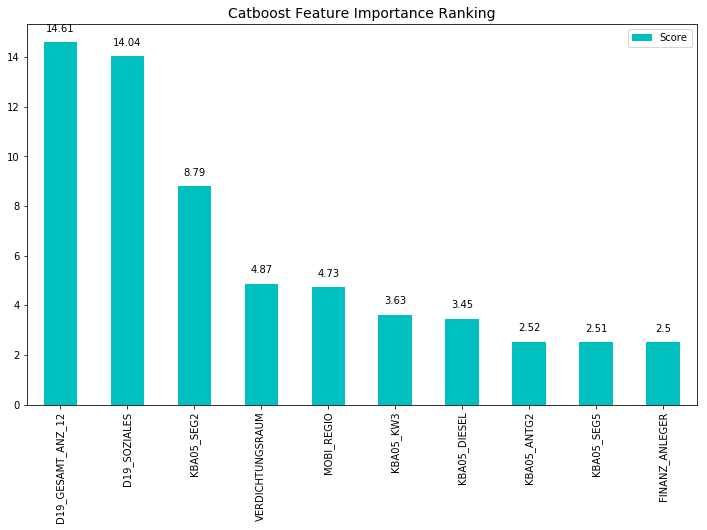

In [32]:
feature_plot(feature_score)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [56]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [155]:
mailout_test_clean = clean_data(mailout_test, iscustomer=False, OutlierRowsRemoval=False)

Processing outlier columns
Cols to be removed:['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ']
ID Col to be removed: LNR
Processing OST_WEST_KZ
1.0    26773
0.0     8433
Name: OST_WEST_KZ, dtype: int64
Processing CAMEO_DEUG_2015
Processing CAMEO_DEU_2015
Processing PRAEGENDE_JUGENDJAHRE
Processing CAMEO_INTL_2015
Processing LP_LEBENSPHASE_FEIN
Processing WOHNLAGE
Processing KBA05_BAUMAX
Processing PLZ8_BAUMAX
Processing D19_LETZTER_KAUF_BRANCHE
Processing EINGEFUEGT_AM
Impute Missing Values
Re-encode Multi-Level Categorical Features
Convert int cols to float


In [156]:
pipeline = create_pipeline(tuned_model, scaler)
pipeline.fit(X, y)
preds = pipeline.predict_proba(mailout_test_clean)[:, 1]

0:	learn: 0.6596335	total: 146ms	remaining: 35.2s
1:	learn: 0.6278195	total: 276ms	remaining: 33.3s
2:	learn: 0.5975660	total: 394ms	remaining: 31.5s
3:	learn: 0.5690030	total: 499ms	remaining: 29.8s
4:	learn: 0.5418796	total: 628ms	remaining: 29.9s
5:	learn: 0.5162872	total: 750ms	remaining: 29.6s
6:	learn: 0.4919509	total: 882ms	remaining: 29.8s
7:	learn: 0.4691127	total: 1.02s	remaining: 29.9s
8:	learn: 0.4473580	total: 1.13s	remaining: 29.5s
9:	learn: 0.4268118	total: 1.27s	remaining: 29.5s
10:	learn: 0.4073846	total: 1.4s	remaining: 29.6s
11:	learn: 0.3889851	total: 1.54s	remaining: 29.6s
12:	learn: 0.3715908	total: 1.67s	remaining: 29.6s
13:	learn: 0.3552979	total: 1.79s	remaining: 29.3s
14:	learn: 0.3398924	total: 1.93s	remaining: 29.4s
15:	learn: 0.3253366	total: 2.05s	remaining: 29.1s
16:	learn: 0.3116080	total: 2.18s	remaining: 29s
17:	learn: 0.2980568	total: 2.31s	remaining: 28.8s
18:	learn: 0.2857554	total: 2.42s	remaining: 28.6s
19:	learn: 0.2741173	total: 2.56s	remaining:

In [157]:
kagglesubmission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds)
kagglesubmission.rename(columns={0: "RESPONSE"}, inplace=True)
kagglesubmission.to_csv('kagglesubmission.csv')

In [158]:
kagglesubmission.shape

(42833, 1)

Kaggle 2nd Submmision:

<img src='./kaggle2ndSubmission.PNG' width=60%>

Kaggle 3rd Submmision:

<img src='./kaggle3rdSubmission.PNG' width=60%>